In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from darts.utils.statistics import stationarity_tests
import darts

In [ ]:
!pip install darts

In [5]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 3.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [58]:
!pip install --upgrade pandas

# 1. Profiling and EDA

In [2]:
#MABUALLY COLLECTED DATA
hnum =['H3','H4','H5','H6','H8','H10','H11','H12','H13','H14']
htype=['modern','character','modern','apartment','character','special','duplex','apartment','special','modern']
facing=['south','west','south','sw','south','south','north','nw','north','south']
#######################################
#function to map valus to levels
def maptolevel(l1,l2,l3,t):
  if t < l1 :
    return 'vlow'
  elif t < l2:
    return 'low'
  elif t < l3:
    return 'high'
  else:
    return 'vhigh'



all_data=[]
for x in range(len(hnum)):
  data = pd.read_csv('/content/drive/MyDrive/iberd/Residential_'+hnum[x][1:]+'.csv',parse_dates=['date'])
  data['type']=htype[x]
  data['hnum']=hnum[x]
  data['facing']=facing[x]
  print('#############################  '+ hnum[x]+ '  #############################')
  print('Number of Records:', data.shape[0])
  print('Number of Days:', data.shape[0]/24)
  print('Mean Energy Consumption per hour:', data['energy_kWh'].mean())
  print('Max Energy Consumption per hour:', data['energy_kWh'].max())
  print('Min Energy Consumption per hour:', data['energy_kWh'].min())
  print('Median Energy Consumption per hour:', data['energy_kWh'].median())
  print('std Energy Consumption per hour:', data['energy_kWh'].std())
  print('% of missing values in '+hnum[x]+ ':', data['energy_kWh'].isna().sum()/ data['energy_kWh'].shape[0])
  #fill using forword filling
  data['energy_kWh'] = data['energy_kWh'].fillna(method='ffill')
  #smooth energy consumption
  data['smth24']=data['energy_kWh'].rolling(24, min_periods=1).mean()
  data['smth168']=data['energy_kWh'].rolling(168, min_periods=1).mean()
  data['smth720']=data['energy_kWh'].rolling(720, min_periods=1).mean()
  #find overusage/underusage
  ouv = data['energy_kWh'].quantile(.75) 
  data['overusage']= data['energy_kWh'].apply(lambda e: 0 if e <= ouv else 1)
  uuv = data['energy_kWh'].quantile(.25)
  data['underusage']= data['energy_kWh'].apply(lambda e: 1 if e < uuv else 0)
  #get week days
  data['weekday']= data['date'].dt.dayofweek
  #get month
  data['month']= data['date'].dt.month
  all_data.append(data)

# concat resd data
all_data= pd.concat(all_data,axis=0)

weather= pd.read_csv('/content/drive/MyDrive/iberd/Weather_YVR.csv',parse_dates=['date'])
#shifit hours by -1 to be the same as resd data
weather['hour']= weather['hour']-1
print('############################# weather data  #############################')
print('% of missing values in temperature:', weather['temperature'].isna().sum()/ weather['temperature'].shape[0])
print('% of missing values in humidity:', weather['humidity'].isna().sum()/ weather['humidity'].shape[0])
print('% of missing values in pressure:', weather['pressure'].isna().sum()/ weather['pressure'].shape[0])
print('% of missing values in weather:', weather['weather'].isna().sum()/ weather['weather'].shape[0])
#smooth weather data (one week)
weather['tempsmth168'] = weather['temperature'].rolling(168, min_periods=1).mean()
weather['humsmth168'] = weather['humidity'].rolling(168, min_periods=1).mean()
weather['presmth168'] = weather['pressure'].rolling(168, min_periods=1).mean()
#merge weather data with red data
all_data= pd.merge(all_data,weather,on=['date','hour'],how='left')
#fill using forword filling
all_data['temperature'] = all_data['temperature'].fillna(method='ffill')
all_data['humidity'] = all_data['humidity'].fillna(method='ffill')
all_data['pressure'] = all_data['pressure'].fillna(method='ffill')

#map temprature values
l1= all_data['temperature'].quantile(.25)
l2= all_data['temperature'].quantile(.50)
l3= all_data['temperature'].quantile(.75)
all_data['temp']= all_data['temperature'].apply(lambda t: maptolevel(l1,l2,l3,t))
#map humidity values
l1= all_data['humidity'].quantile(.25)
l2= all_data['humidity'].quantile(.50)
l3= all_data['humidity'].quantile(.75)
all_data['hum']= all_data['humidity'].apply(lambda t: maptolevel(l1,l2,l3,t))

#############################  H3  #############################
Number of Records: 26376
Number of Days: 1099.0
Mean Energy Consumption per hour: 0.9251901213704048
Max Energy Consumption per hour: 5.65
Min Energy Consumption per hour: 0.0
Median Energy Consumption per hour: 0.67
std Energy Consumption per hour: 0.6786768144777343
% of missing values in H3: 0.012890506521079769
#############################  H4  #############################
Number of Records: 26304
Number of Days: 1096.0
Mean Energy Consumption per hour: 1.2211531703590568
Max Energy Consumption per hour: 6.78
Min Energy Consumption per hour: 0.21
Median Energy Consumption per hour: 1.06
std Energy Consumption per hour: 0.7319059219160057
% of missing values in H4: 0.0047141119221411195
#############################  H5  #############################
Number of Records: 26304
Number of Days: 1096.0
Mean Energy Consumption per hour: 0.7568755732191985
Max Energy Consumption per hour: 8.12
Min Energy Consumption per hou

In [ ]:
all_data.tail(50)

Text(0.5, 1.0, 'Energy Consumption Per Hour (no Smoothing)')

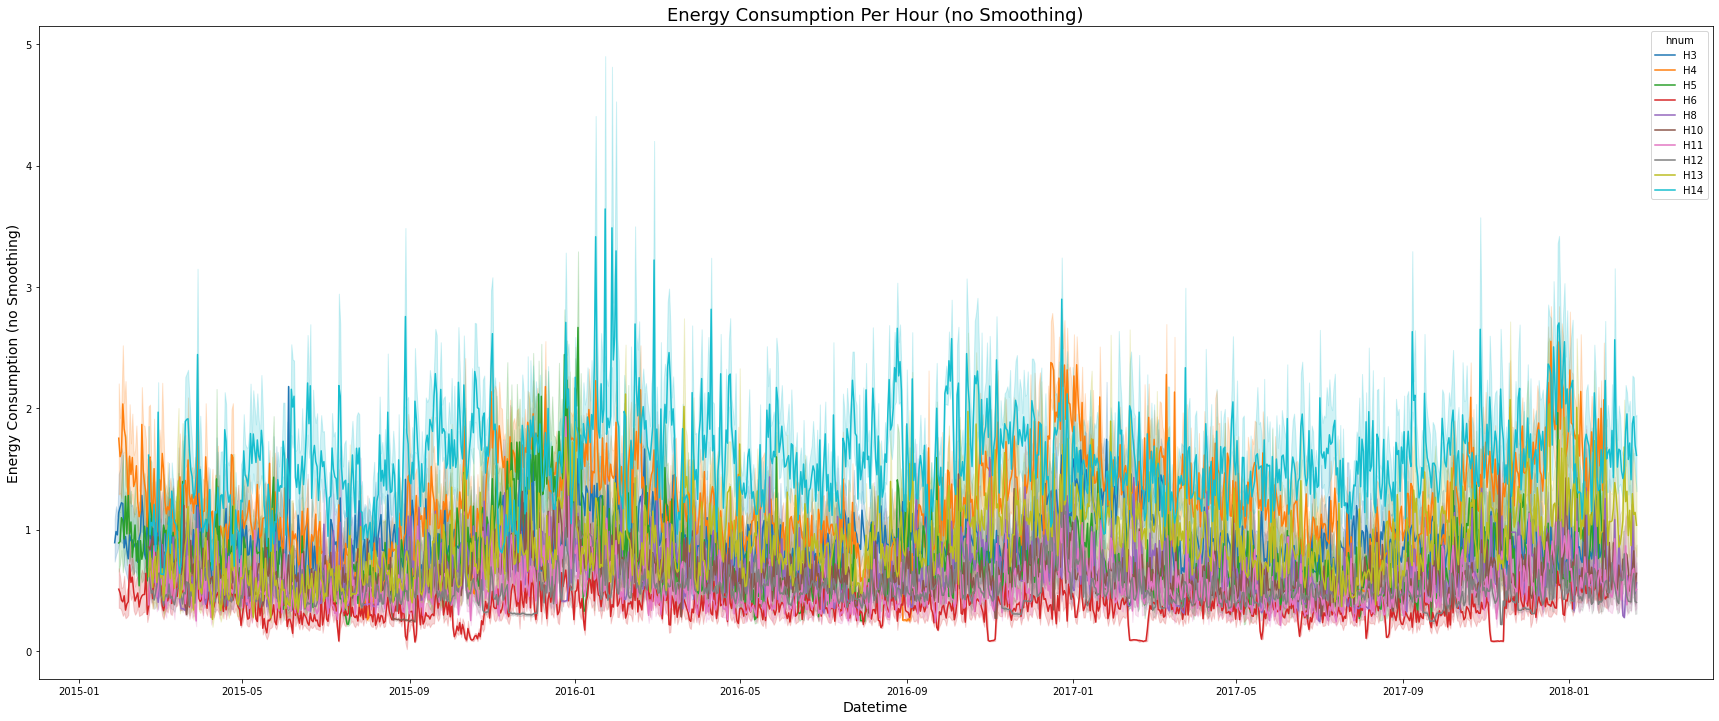

In [17]:
plt.figure(figsize=(30,12))
sns.lineplot(data=all_data, x="date", y="energy_kWh", hue="hnum")
plt.ylabel("Energy Consumption (no Smoothing)", size=14)
plt.xlabel("Datetime", size=14)
plt.title("Energy Consumption Per Hour (no Smoothing)", size=18)

Text(0.5, 1.0, 'Energy Consumption Per Hour (24h Smoothing)')

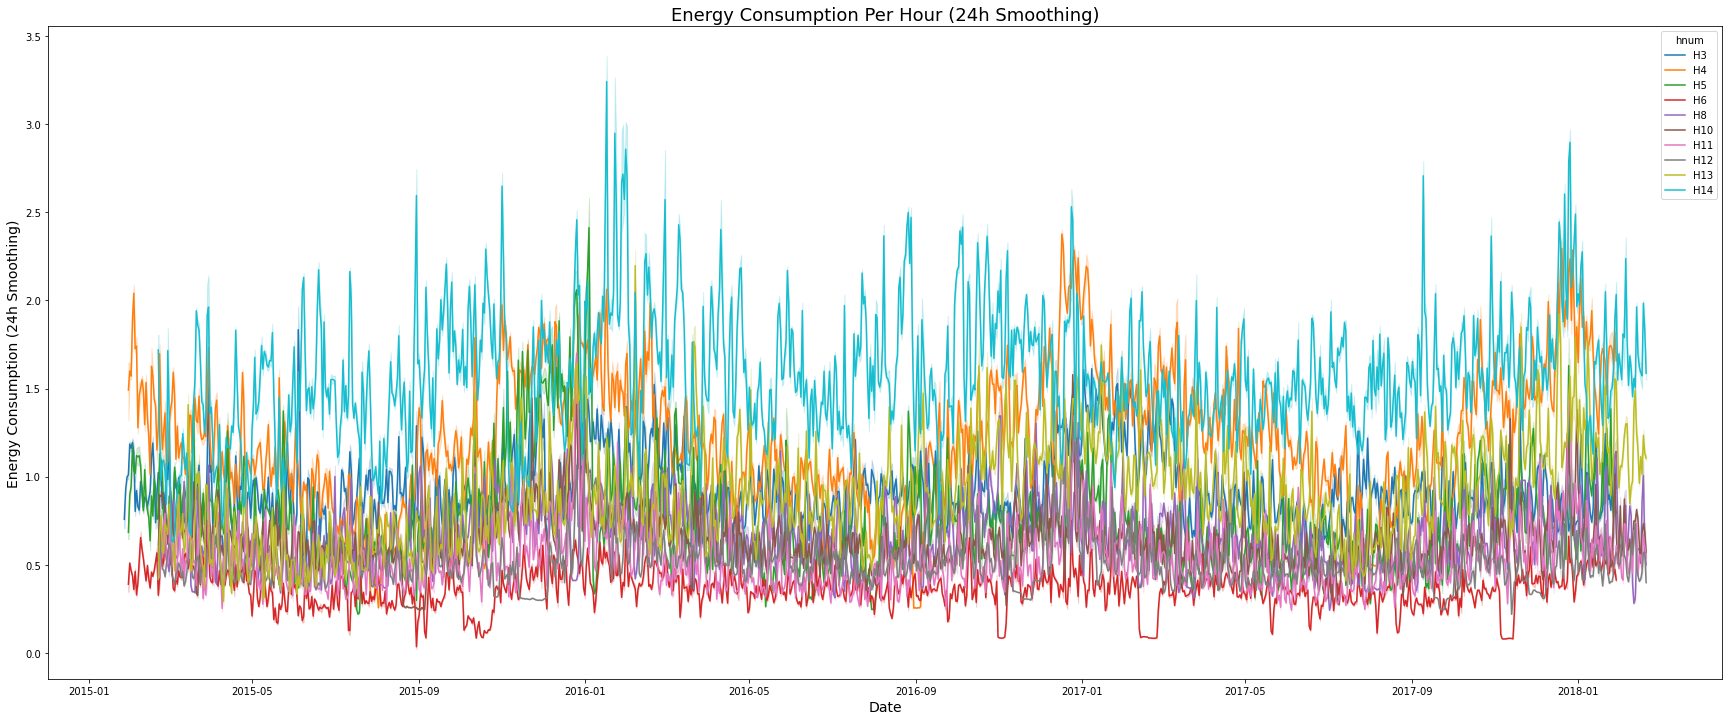

In [24]:
plt.figure(figsize=(30,12))
sns.lineplot(data=all_data, x="date", y="smth24", hue="hnum")
plt.ylabel("Energy Consumption (24h Smoothing)", size=14)
plt.xlabel("Date", size=14)
plt.title("Energy Consumption Per Hour (24h Smoothing)", size=18)

Text(0.5, 1.0, 'Energy Consumption Per Hour (week Smoothing)')

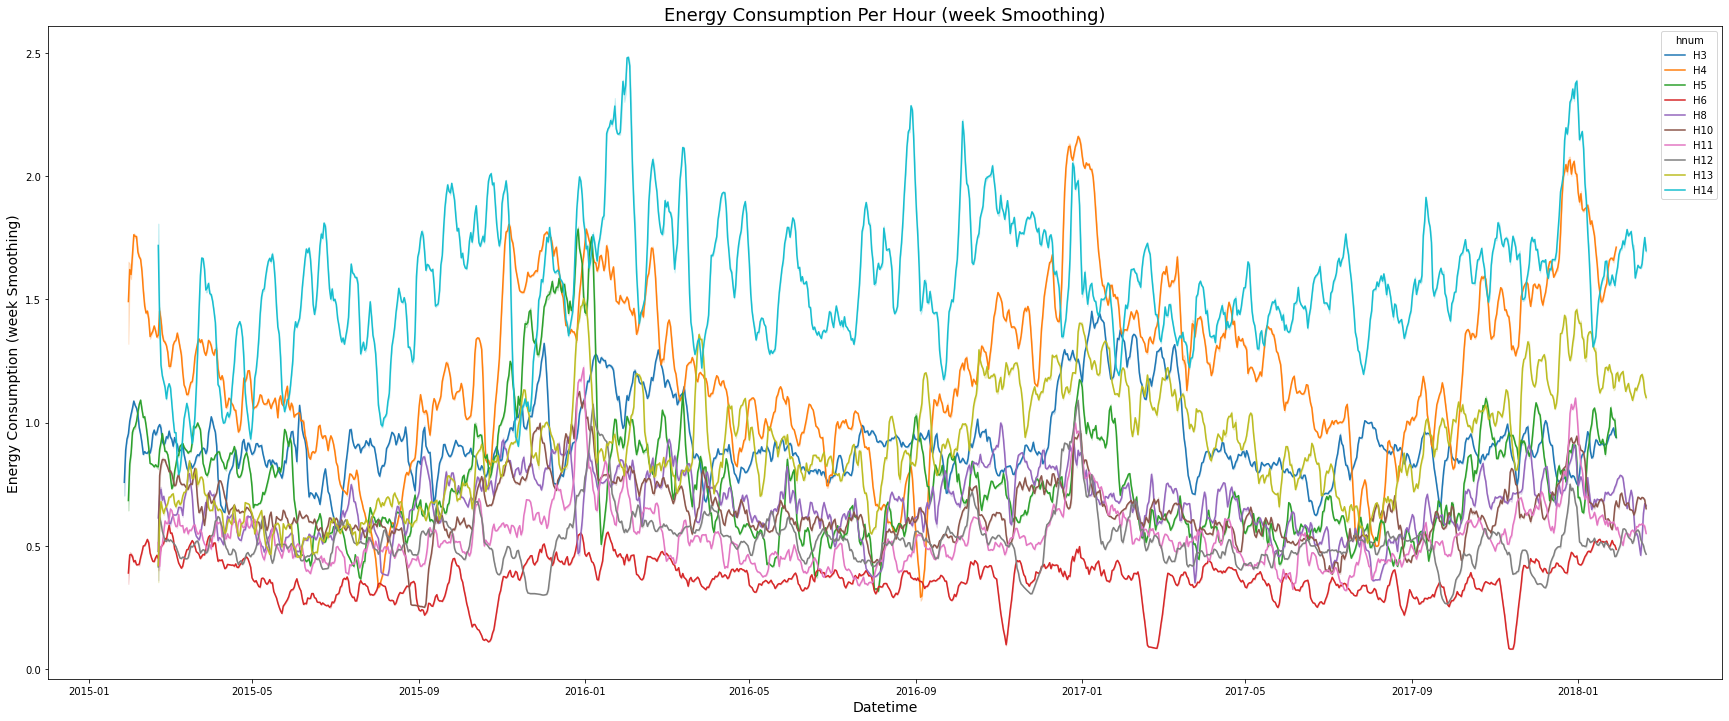

In [25]:
plt.figure(figsize=(30,12))
sns.lineplot(data=all_data, x="date", y="smth168", hue="hnum")
plt.ylabel("Energy Consumption (week Smoothing)", size=14)
plt.xlabel("Datetime", size=14)
plt.title("Energy Consumption Per Hour (week Smoothing)", size=18)

Text(0.5, 1.0, 'Energy Consumption Per Hour (month Smoothing)')

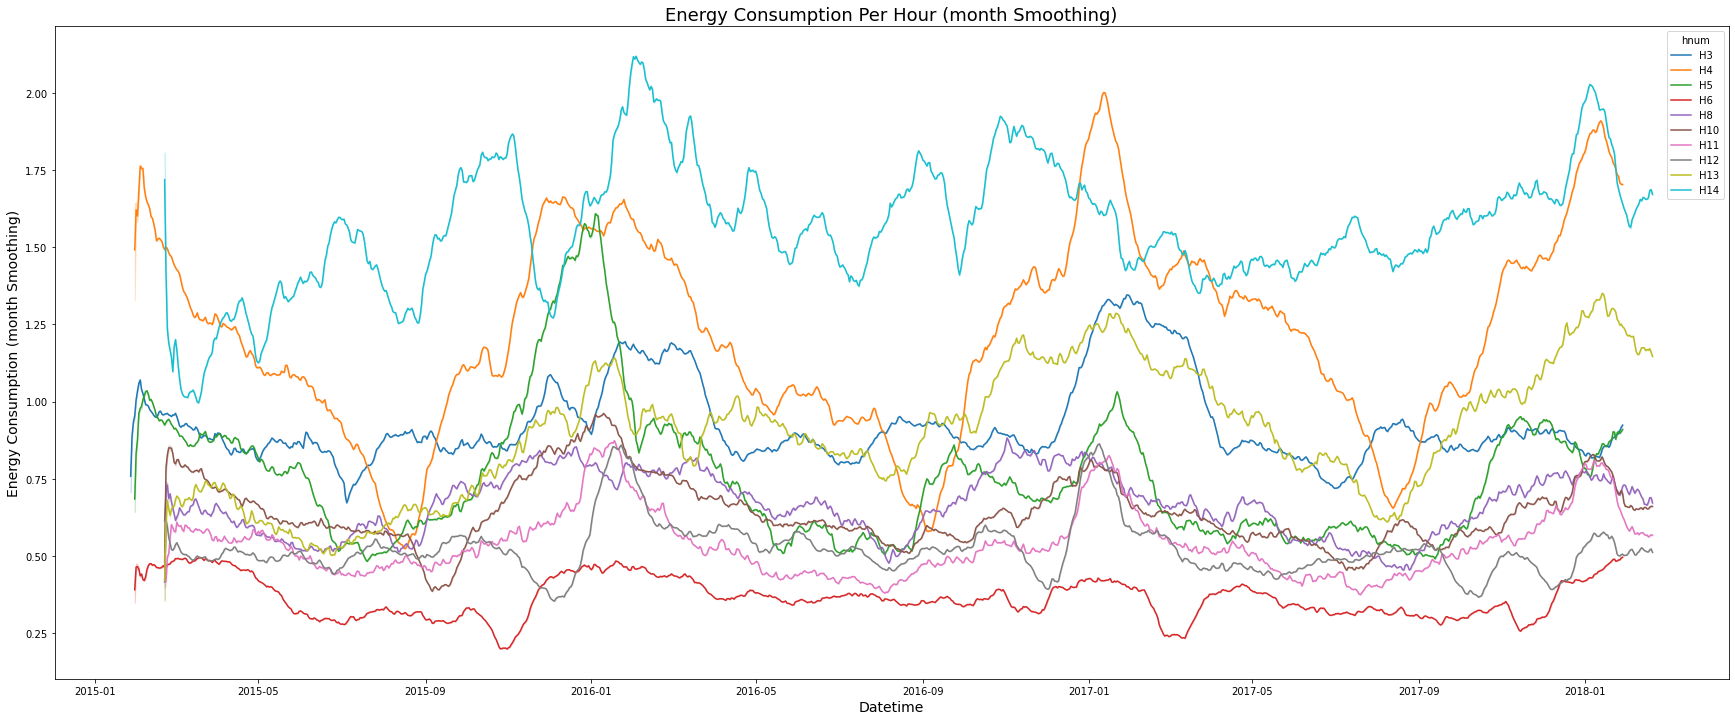

In [29]:
plt.figure(figsize=(30,12))
sns.lineplot(data=all_data, x="date", y="smth720", hue="hnum")
plt.ylabel("Energy Consumption (month Smoothing)", size=14)
plt.xlabel("Datetime", size=14)
plt.title("Energy Consumption Per Hour (month Smoothing)", size=18)

Text(0.5, 1.0, ' Daily Energy Consumption (10 Resd )')

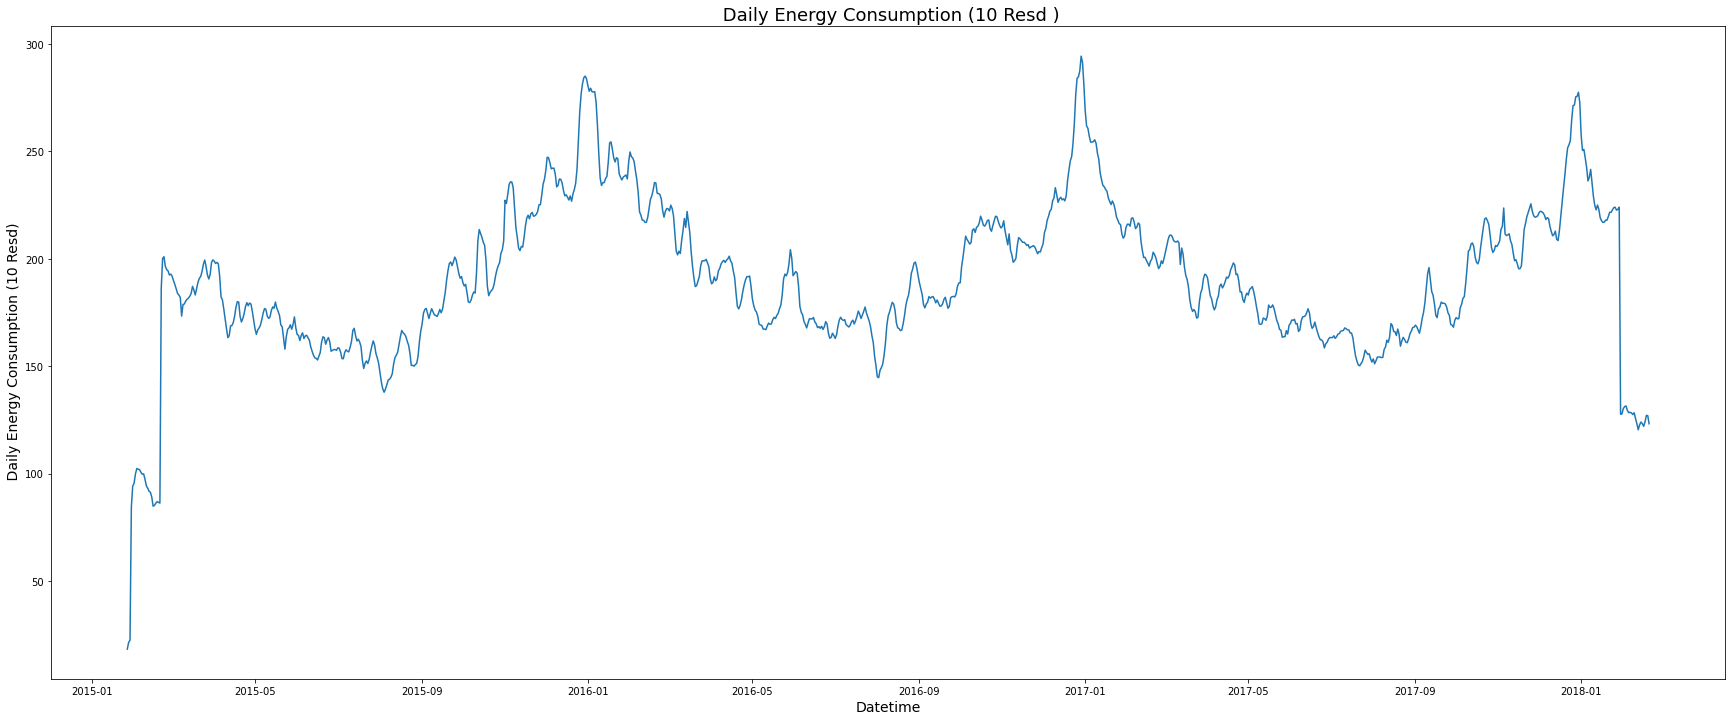

In [38]:
plt.figure(figsize=(30,12))
sns.lineplot(data=all_data.groupby(['date']).sum().reset_index(), x="date", y="smth168")
plt.ylabel(" Daily Energy Consumption (10 Resd)", size=14)
plt.xlabel("Datetime", size=14)
plt.title(" Daily Energy Consumption (10 Resd )", size=18)

Text(0.5, 1.0, ' Sum of Daily Energy Consumption for all Houses and Temperature (one week smooth) ')

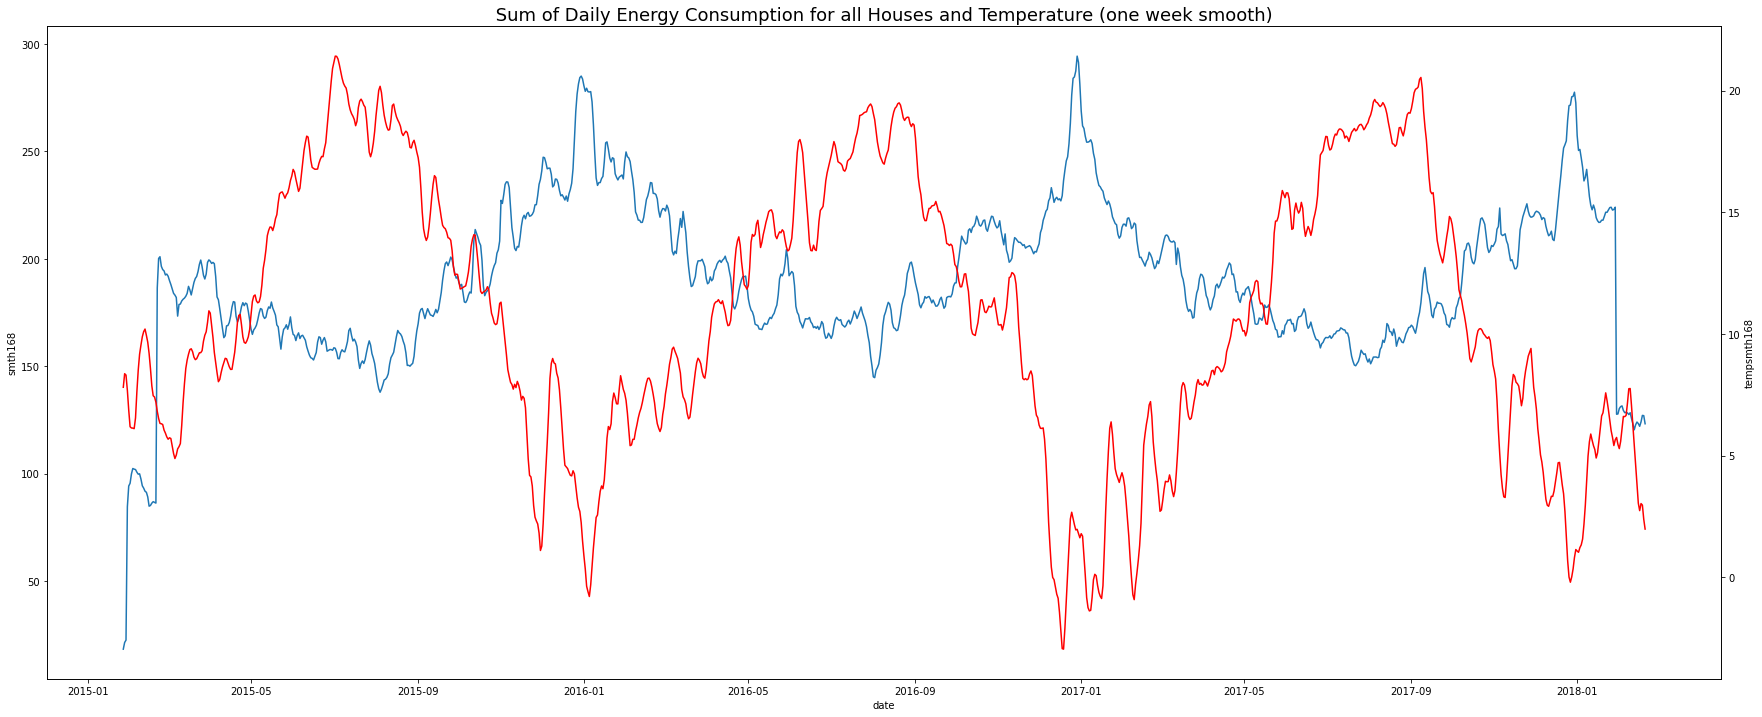

In [45]:
plt.figure(figsize=(30,12))
ax =sns.lineplot(data=all_data.groupby(['date']).sum().reset_index(), x="date", y="smth168")
ax2 = plt.twinx()
sns.lineplot(data=all_data.groupby(['date']).mean().reset_index(), x="date", y="tempsmth168", color="r",ax=ax2)
#ax.figure.legend()
#plt.ylabel("temperature", size=14)
#plt.xlabel("Datetime", size=14)
plt.title(" Sum of Daily Energy Consumption for all Houses and Temperature (one week smooth) ", size=18)

Text(0.5, 1.0, ' Sum of Daily Energy Consumption for all Houses and humidity (one week smooth) ')

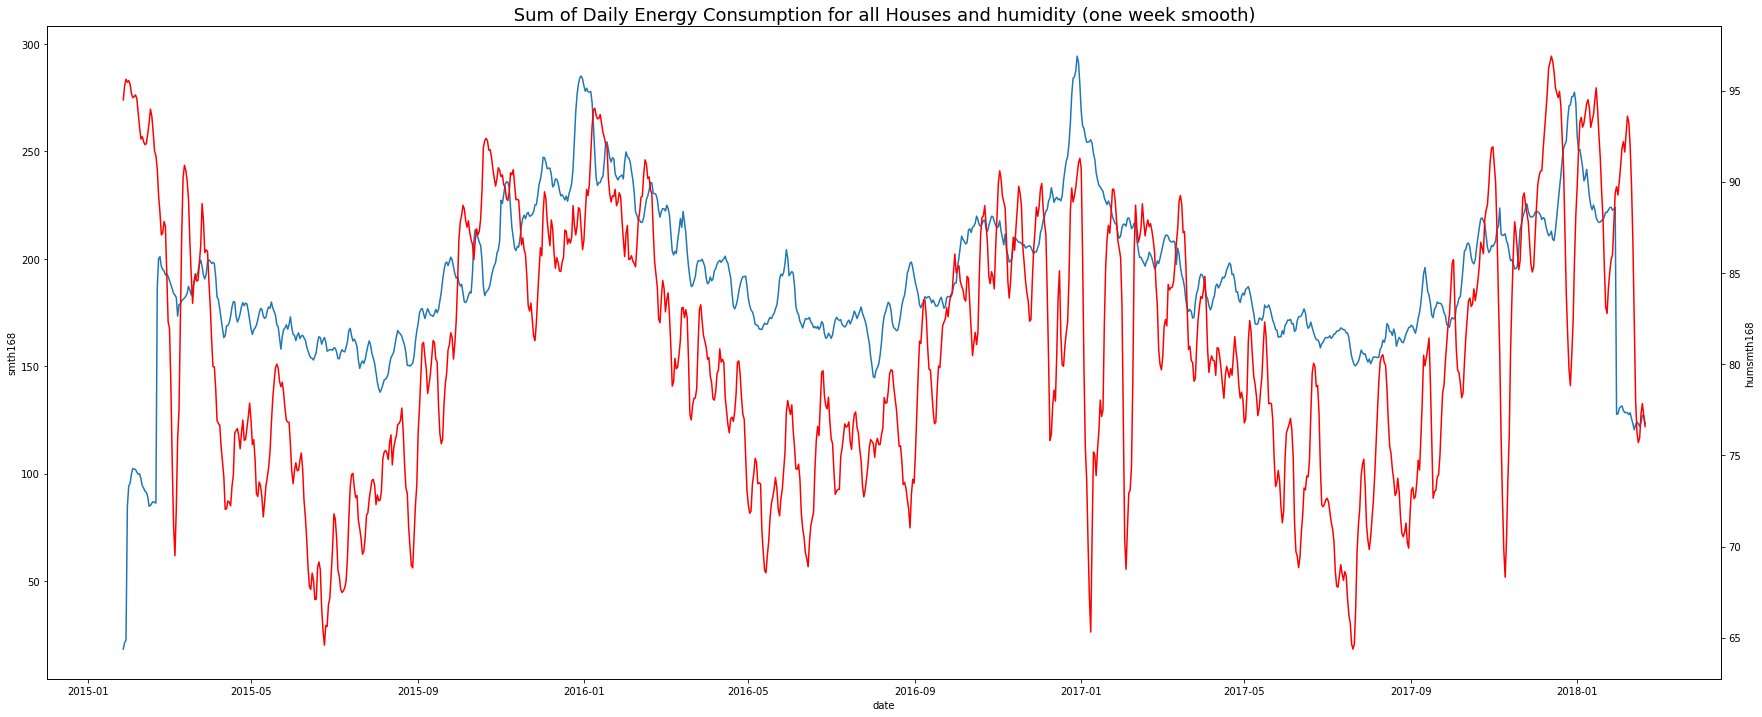

In [47]:
plt.figure(figsize=(30,12))
ax =sns.lineplot(data=all_data.groupby(['date']).sum().reset_index(), x="date", y="smth168")
ax2 = plt.twinx()
sns.lineplot(data=all_data.groupby(['date']).mean().reset_index(), x="date", y="humsmth168", color="r",ax=ax2)
#ax.figure.legend()
#plt.ylabel("temperature", size=14)
#plt.xlabel("Datetime", size=14)
plt.title(" Sum of Daily Energy Consumption for all Houses and humidity (one week smooth) ", size=18)

Text(0.5, 1.0, ' Sum of Daily Energy Consumption for all Houses and pressure (one week smooth) ')

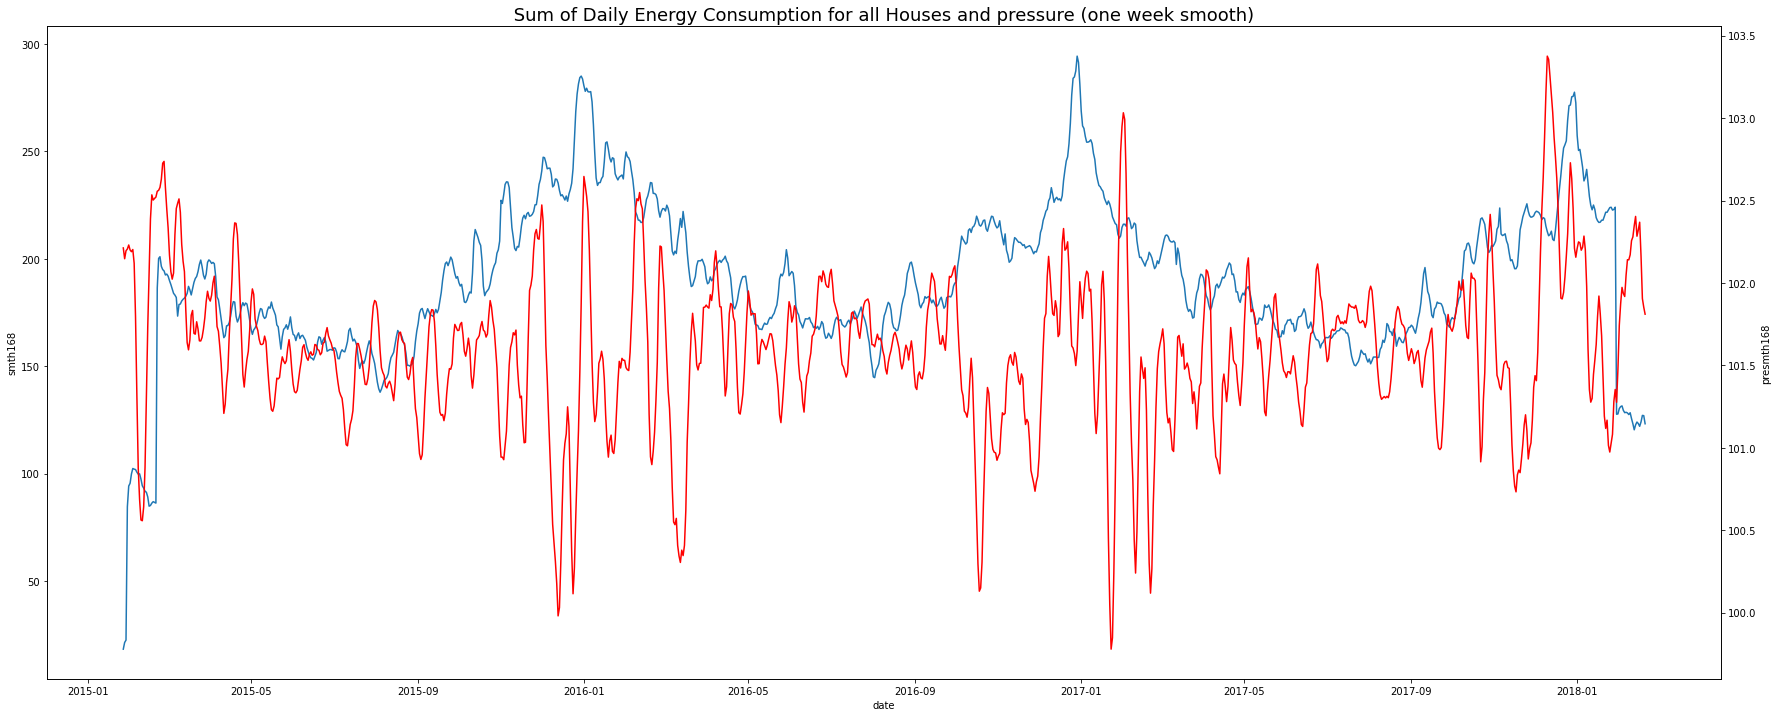

In [49]:
plt.figure(figsize=(30,12))
ax =sns.lineplot(data=all_data.groupby(['date']).sum().reset_index(), x="date", y="smth168")
ax2 = plt.twinx()
sns.lineplot(data=all_data.groupby(['date']).mean().reset_index(), x="date", y="presmth168", color="r",ax=ax2)
#ax.figure.legend()
#plt.ylabel("temperature", size=14)
#plt.xlabel("Datetime", size=14)
plt.title(" Sum of Daily Energy Consumption for all Houses and pressure (one week smooth) ", size=18)

Text(0.5, 1.0, 'Mean Energy Consumption Per Hour')

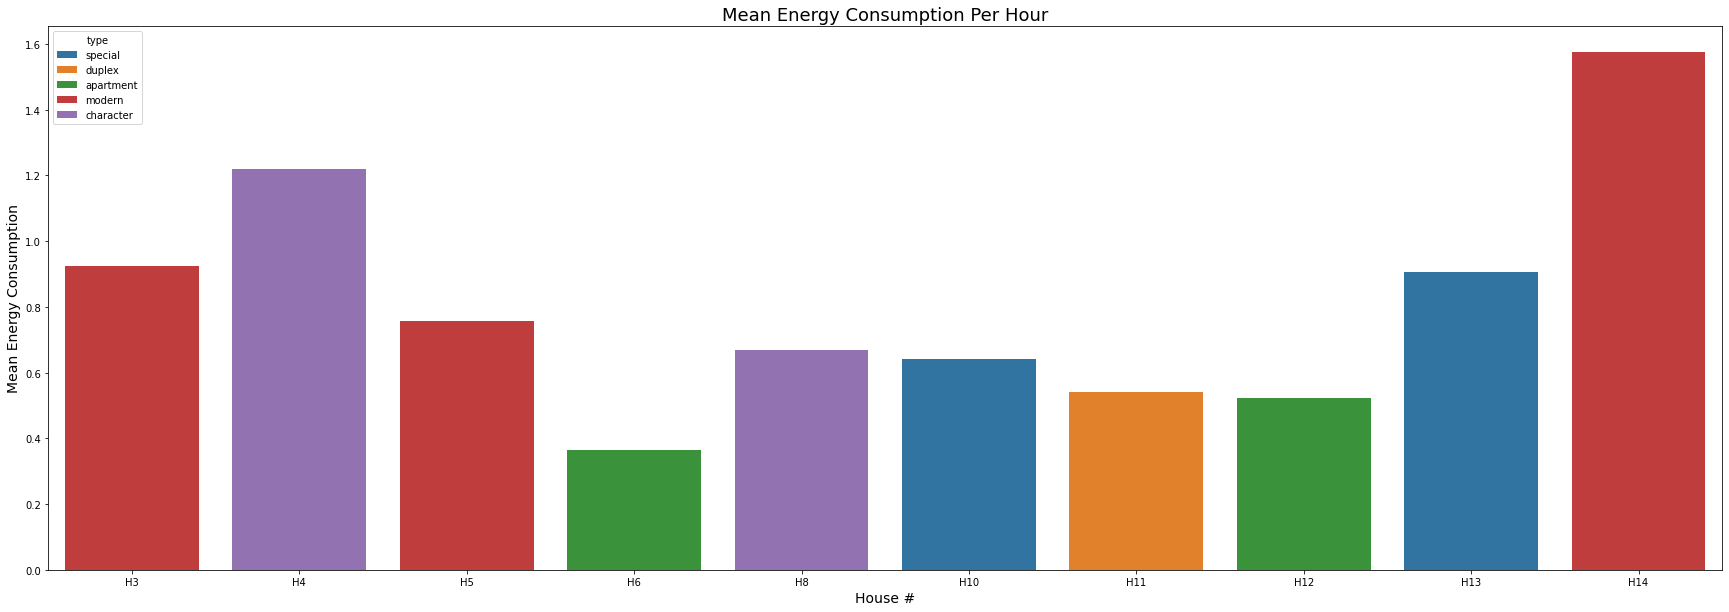

In [4]:
plt.figure(figsize=(30,10))
sns.barplot(x="hnum", y="energy_kWh", data=all_data.groupby(['hnum','type']).mean().reset_index(),hue='type', dodge=False, order=hnum )
plt.ylabel("Mean Energy Consumption", size=14)
plt.xlabel("House #", size=14)
plt.title("Mean Energy Consumption Per Hour", size=18)

Text(0.5, 1.0, 'Mean Energy Consumption Per Hour')

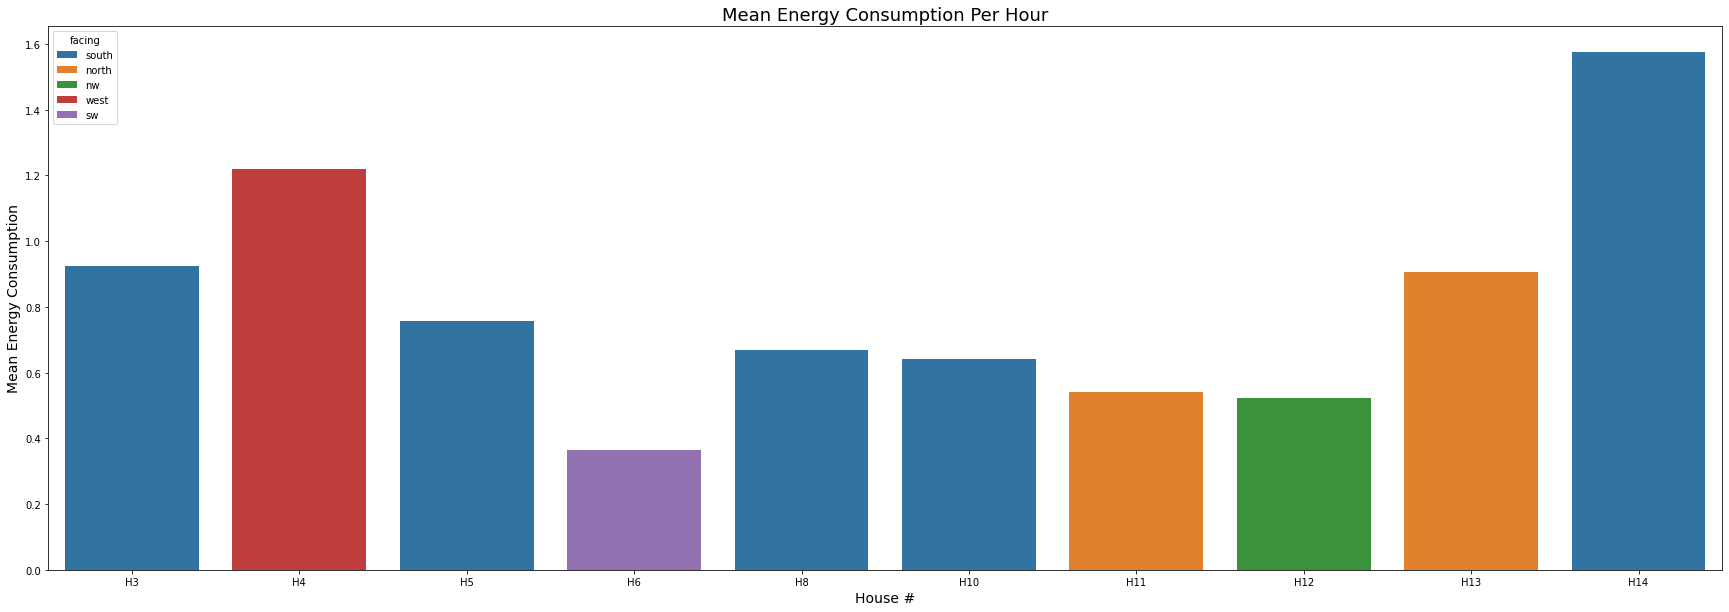

In [30]:
plt.figure(figsize=(30,10))
sns.barplot(x="hnum", y="energy_kWh", data=all_data.groupby(['hnum','facing']).mean().reset_index(),hue='facing', dodge=False, order=hnum )
plt.ylabel("Mean Energy Consumption", size=14)
plt.xlabel("House #", size=14)
plt.title("Mean Energy Consumption Per Hour", size=18)

Text(0.5, 0.98, 'Mean Hourly Consumption at each hour')

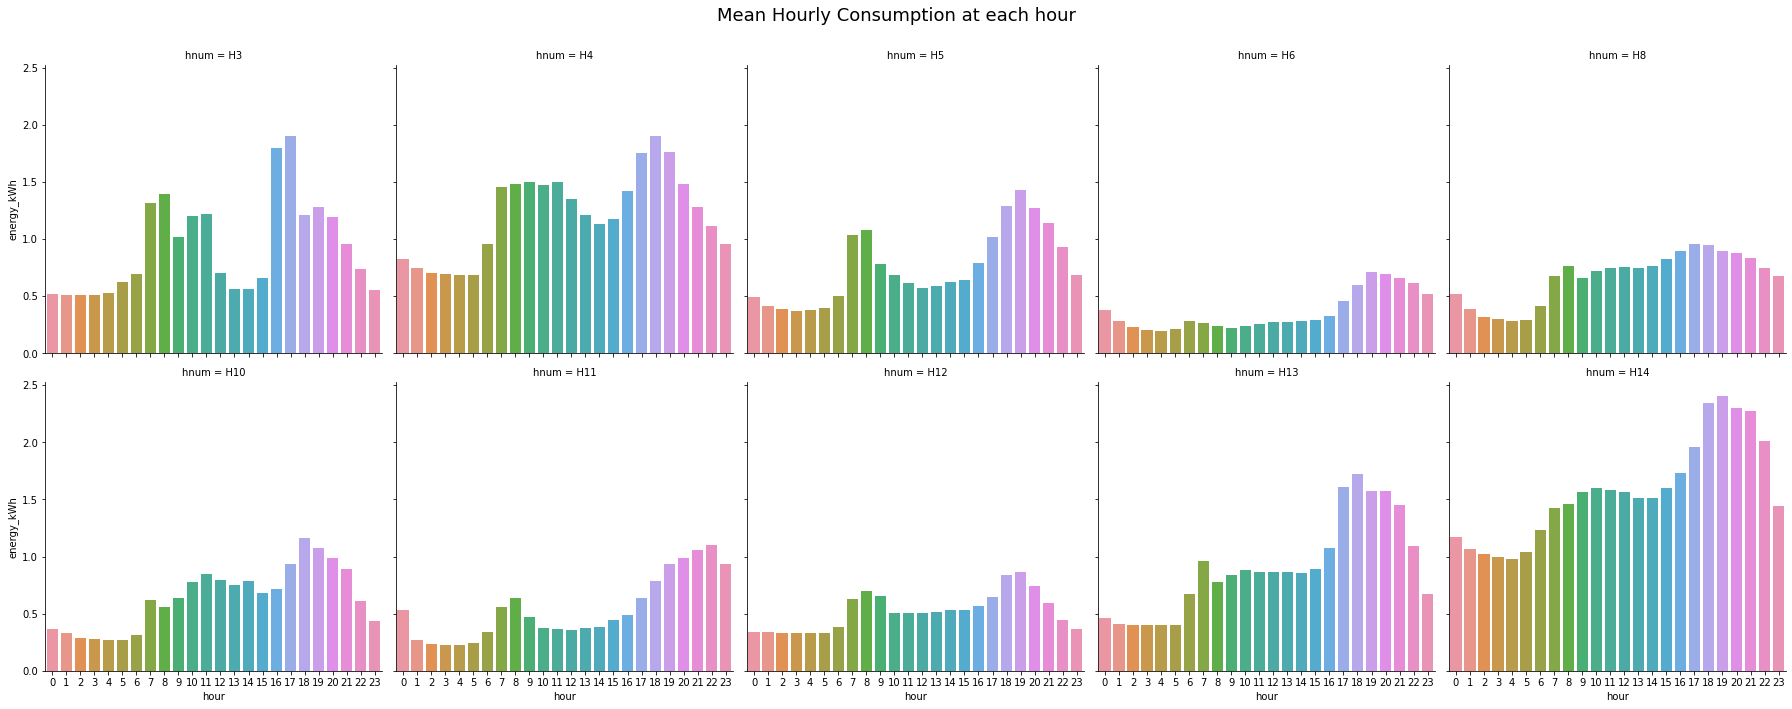

In [15]:
ax=sns.catplot(x="hour", y="energy_kWh" , col="hnum",data=all_data, kind="bar",ci=None, col_wrap=5)
ax.fig.subplots_adjust(top=0.9) 
ax.fig.suptitle('Mean Hourly Consumption at each hour',size=18)


Text(0.5, 0.98, 'Mean Hourly  Consumption on each weekday')

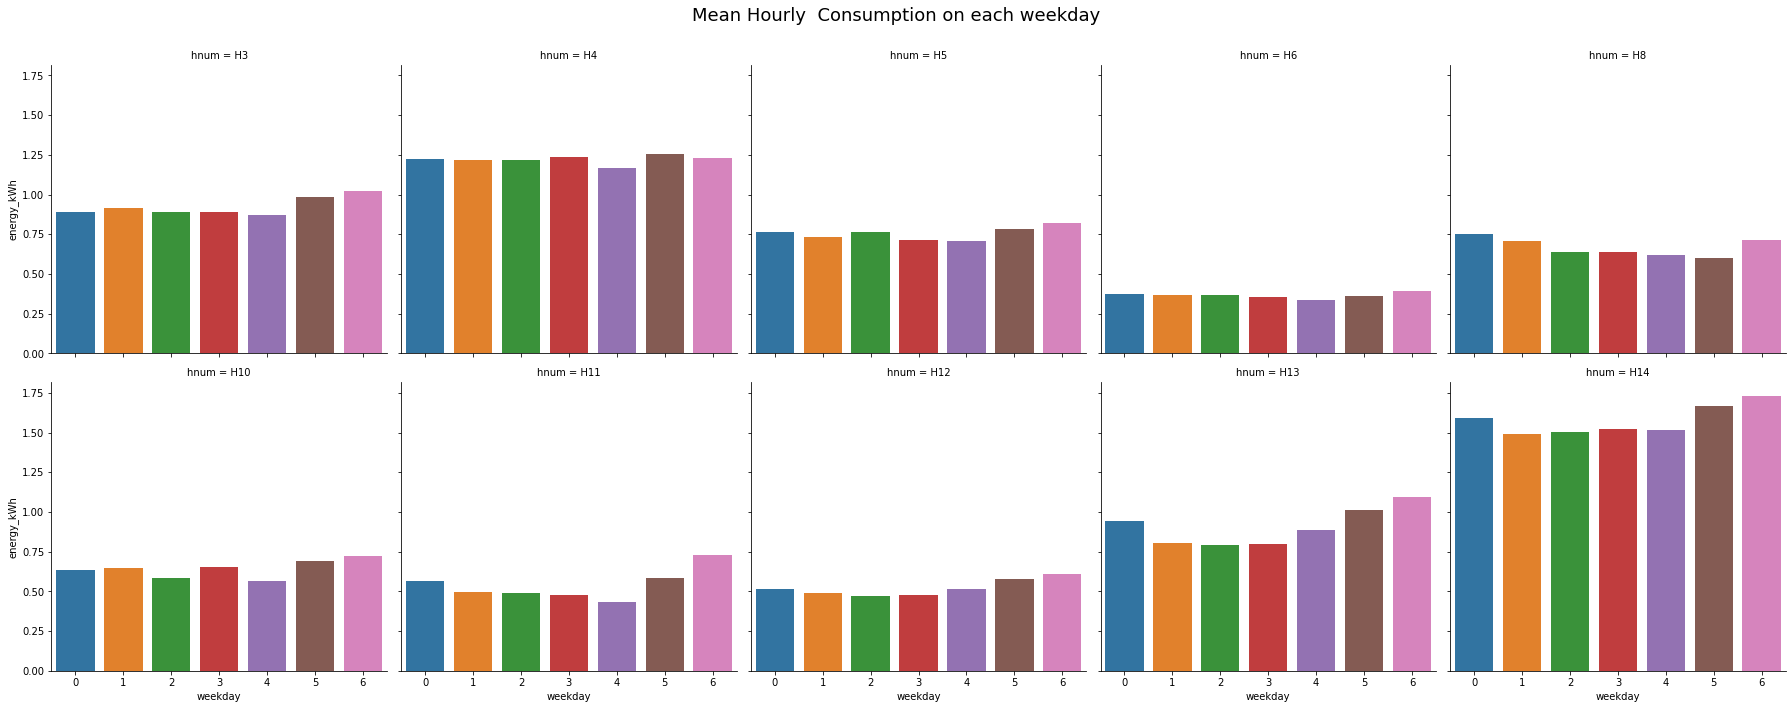

In [17]:
ax=sns.catplot(x="weekday", y="energy_kWh" , col="hnum",data=all_data, kind="bar",ci=None, col_wrap=5)
ax.fig.subplots_adjust(top=0.9) 
ax.fig.suptitle('Mean Hourly  Consumption on each weekday',size=18)

Text(0.5, 0.98, 'Mean Hourly Consumption in each month')

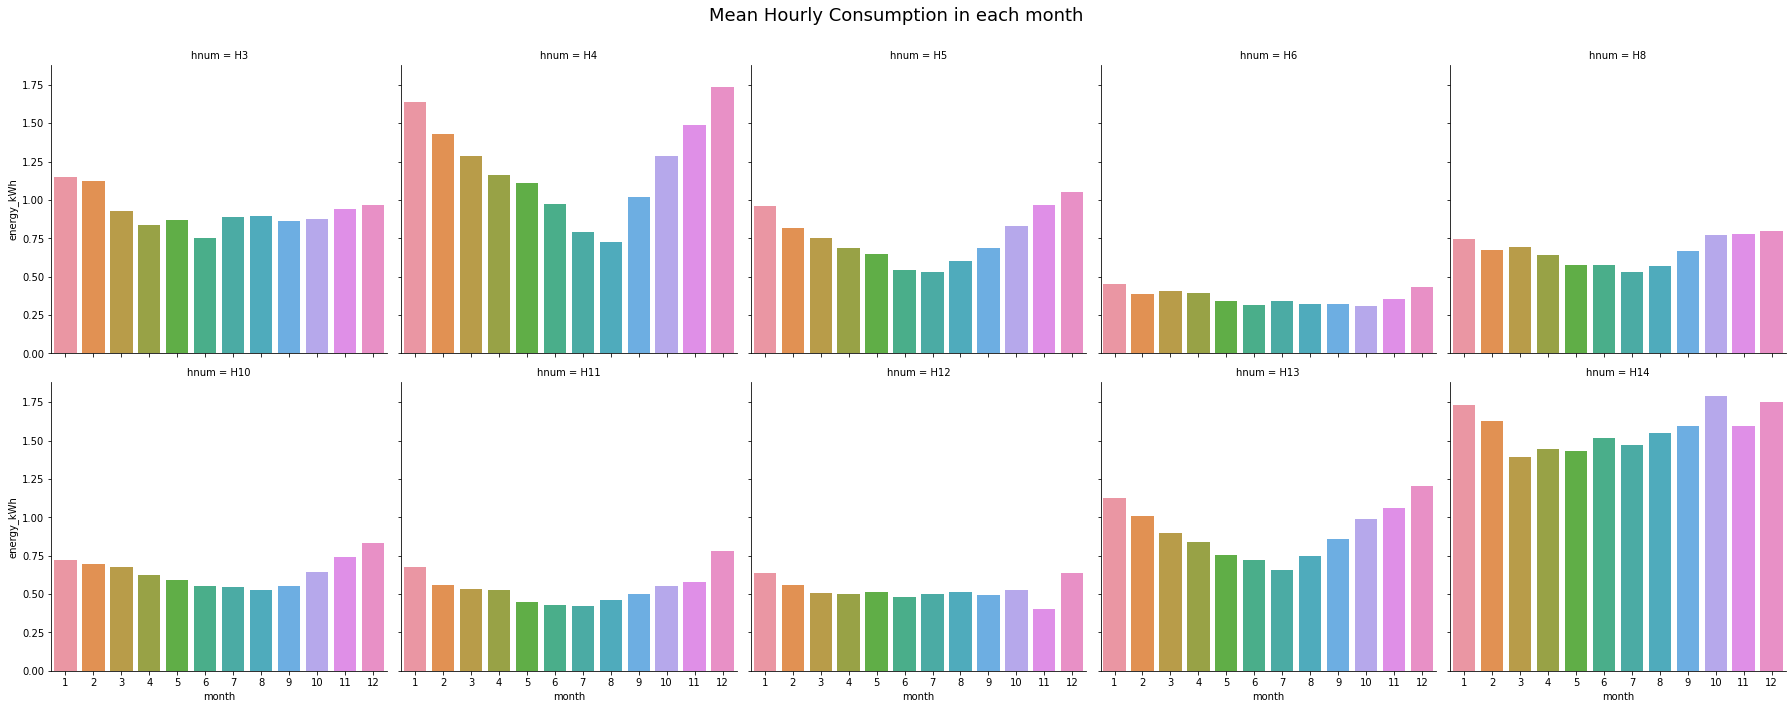

In [18]:
ax=sns.catplot(x="month", y="energy_kWh" , col="hnum",data=all_data, kind="bar",ci=None, col_wrap=5)
ax.fig.subplots_adjust(top=0.9) 
ax.fig.suptitle('Mean Hourly Consumption in each month',size=18)

Text(0.5, 1.0, 'Energy Consumption Per Hour')

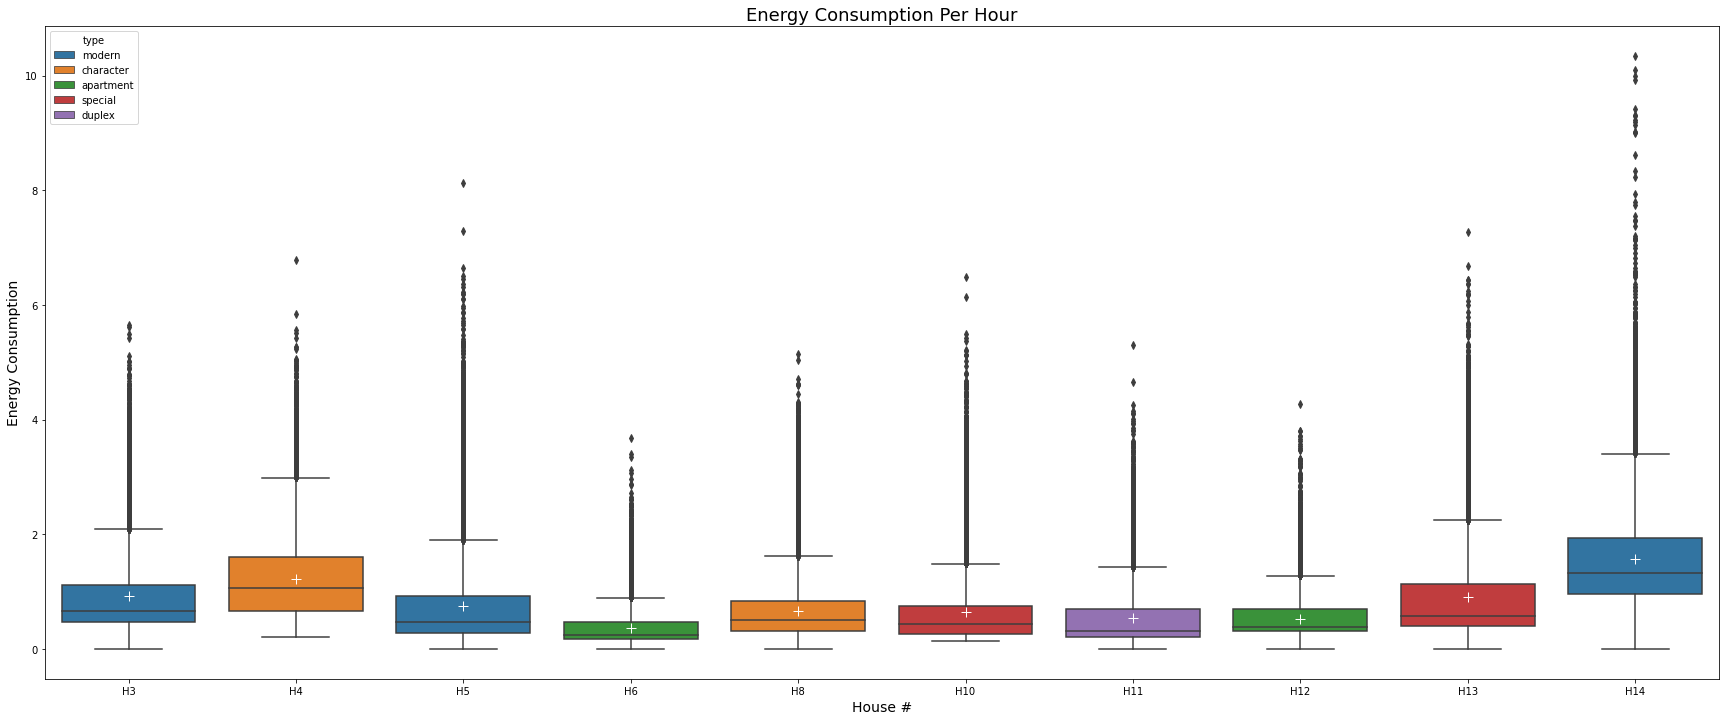

In [5]:
plt.figure(figsize=(30,12))
sns.boxplot(x="hnum", y="energy_kWh", data=all_data, hue='type', dodge=False,order=hnum,showmeans=True,
            meanprops={"marker": "+", "markeredgecolor": "white", "markersize": "10"} )
plt.ylabel("Energy Consumption", size=14)
plt.xlabel("House #", size=14)
plt.title("Energy Consumption Per Hour", size=18)


Text(0.5, 1.0, 'Energy Consumption Per Hour')

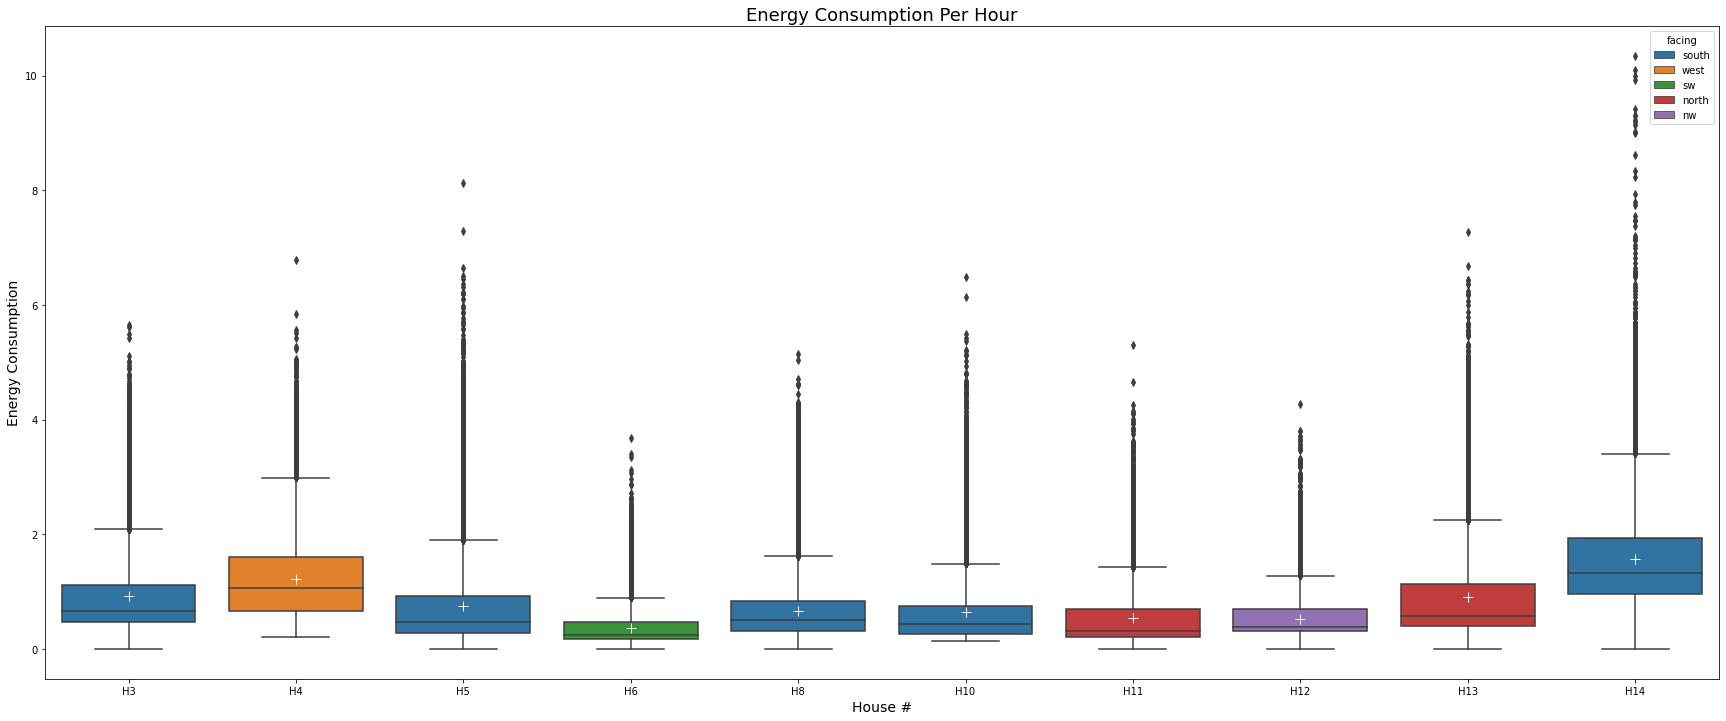

In [6]:
plt.figure(figsize=(30,12))
sns.boxplot(x="hnum", y="energy_kWh", data=all_data, hue='facing', dodge=False,order=hnum,showmeans=True,
            meanprops={"marker": "+", "markeredgecolor": "white", "markersize": "10"} )
plt.ylabel("Energy Consumption", size=14)
plt.xlabel("House #", size=14)
plt.title("Energy Consumption Per Hour", size=18)

# When overusage/underusage?

## Hours

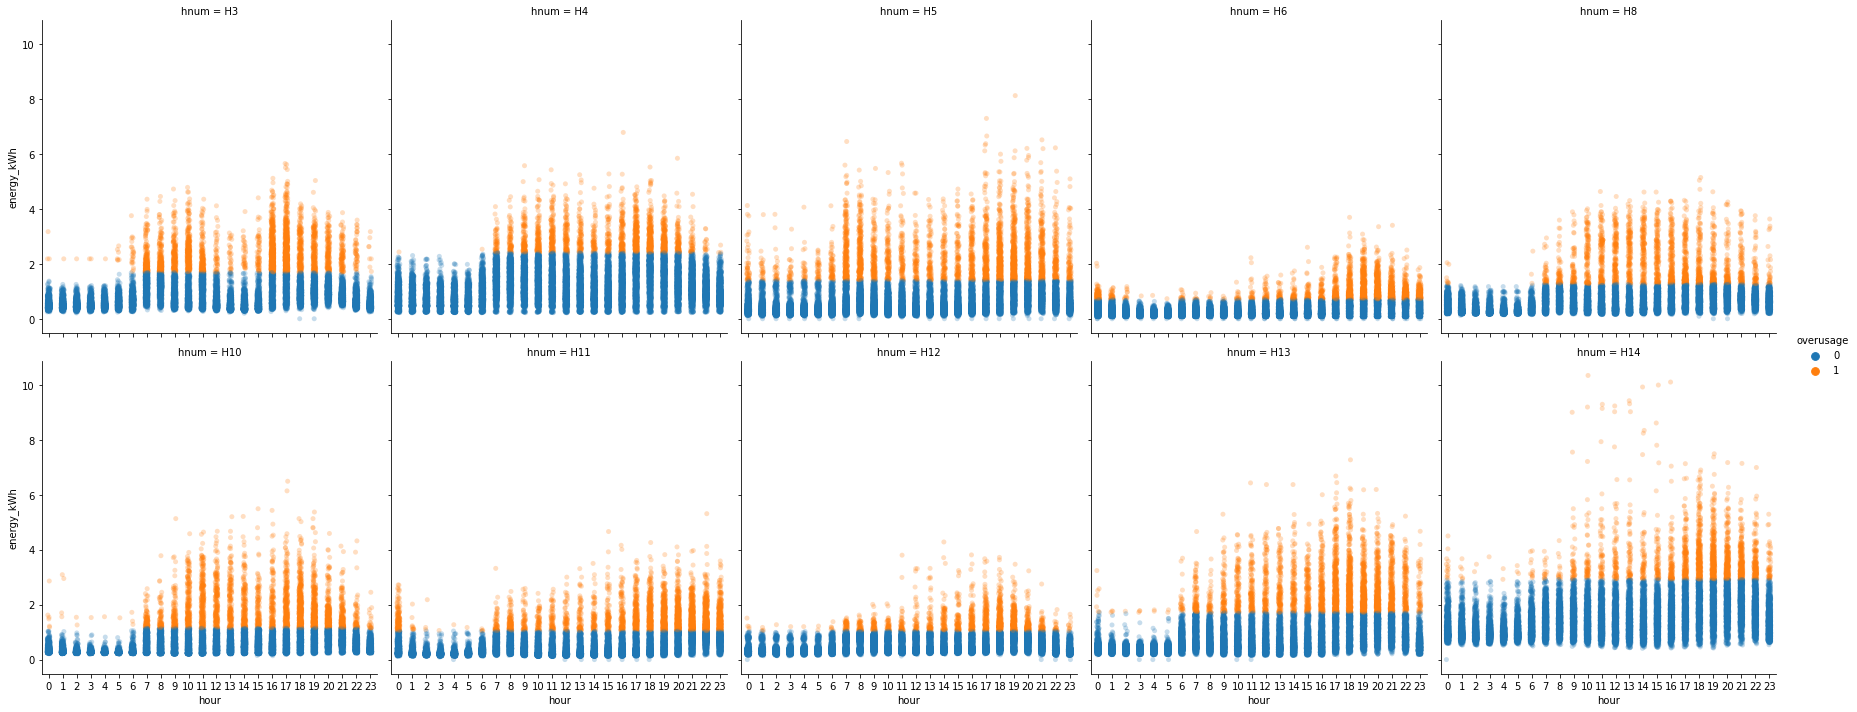

In [4]:
sns.catplot(x="hour", y="energy_kWh",hue="overusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25)

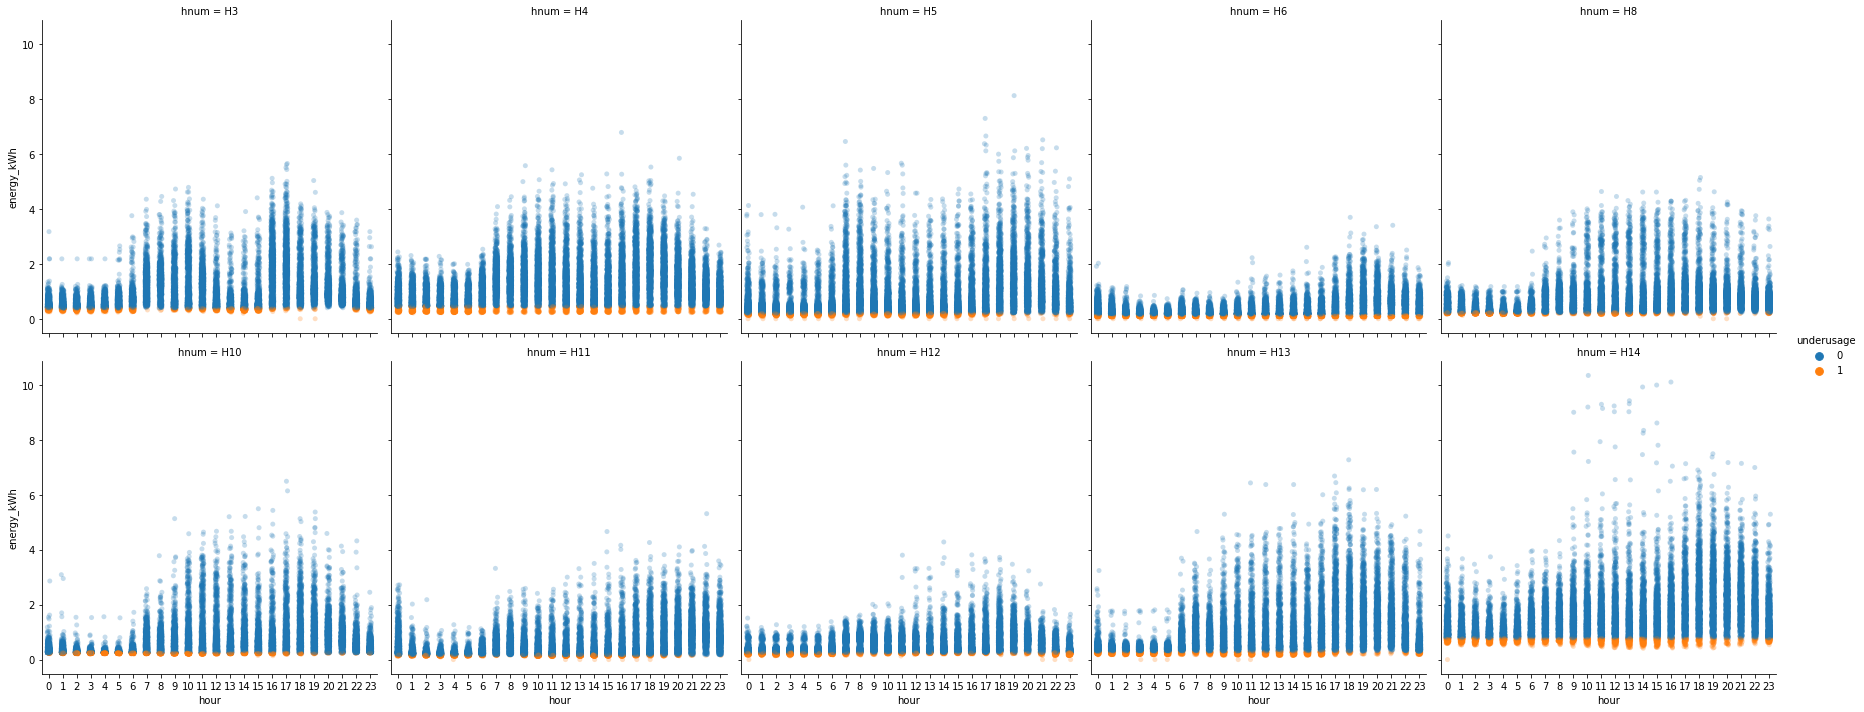

In [5]:
sns.catplot(x="hour", y="energy_kWh",hue="underusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25);

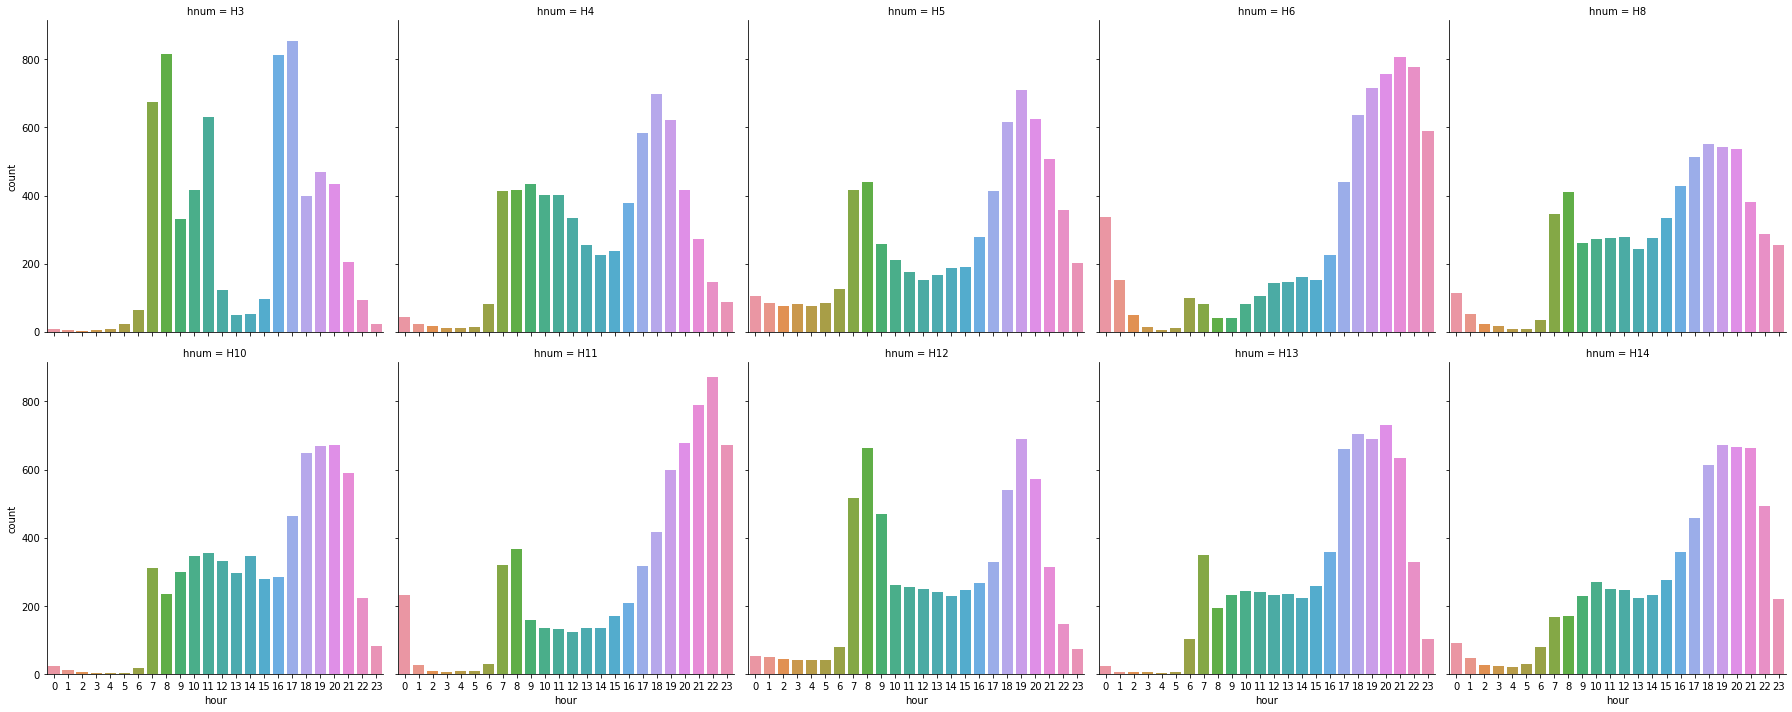

In [9]:
sns.catplot(x="hour", col="hnum",data=all_data[all_data['overusage']==1], kind="count", col_wrap=5)

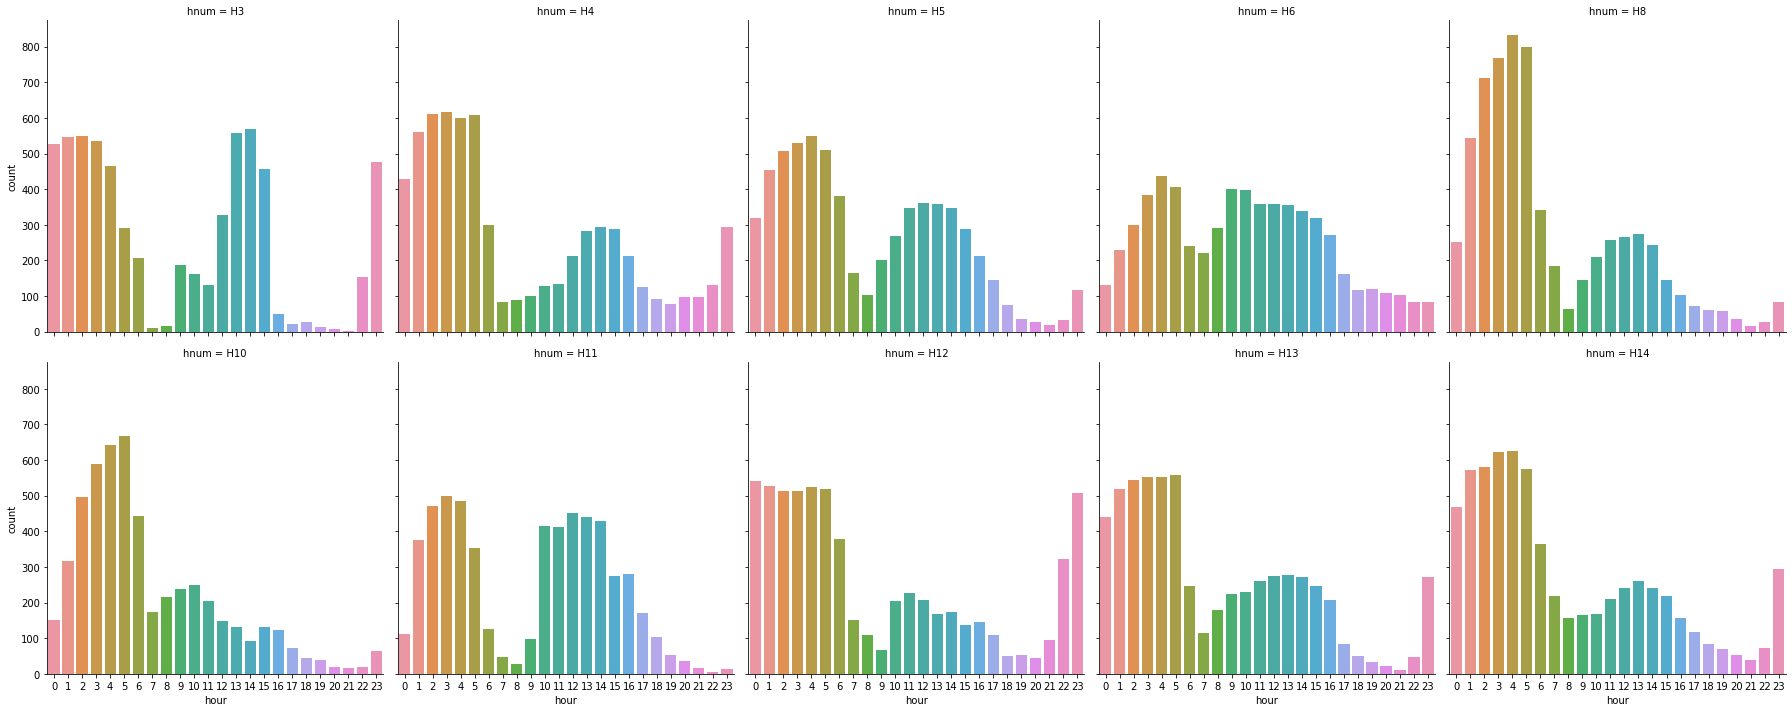

In [10]:
sns.catplot(x="hour", col="hnum",data=all_data[all_data['underusage']==1], kind="count", col_wrap=5)

## Week Days

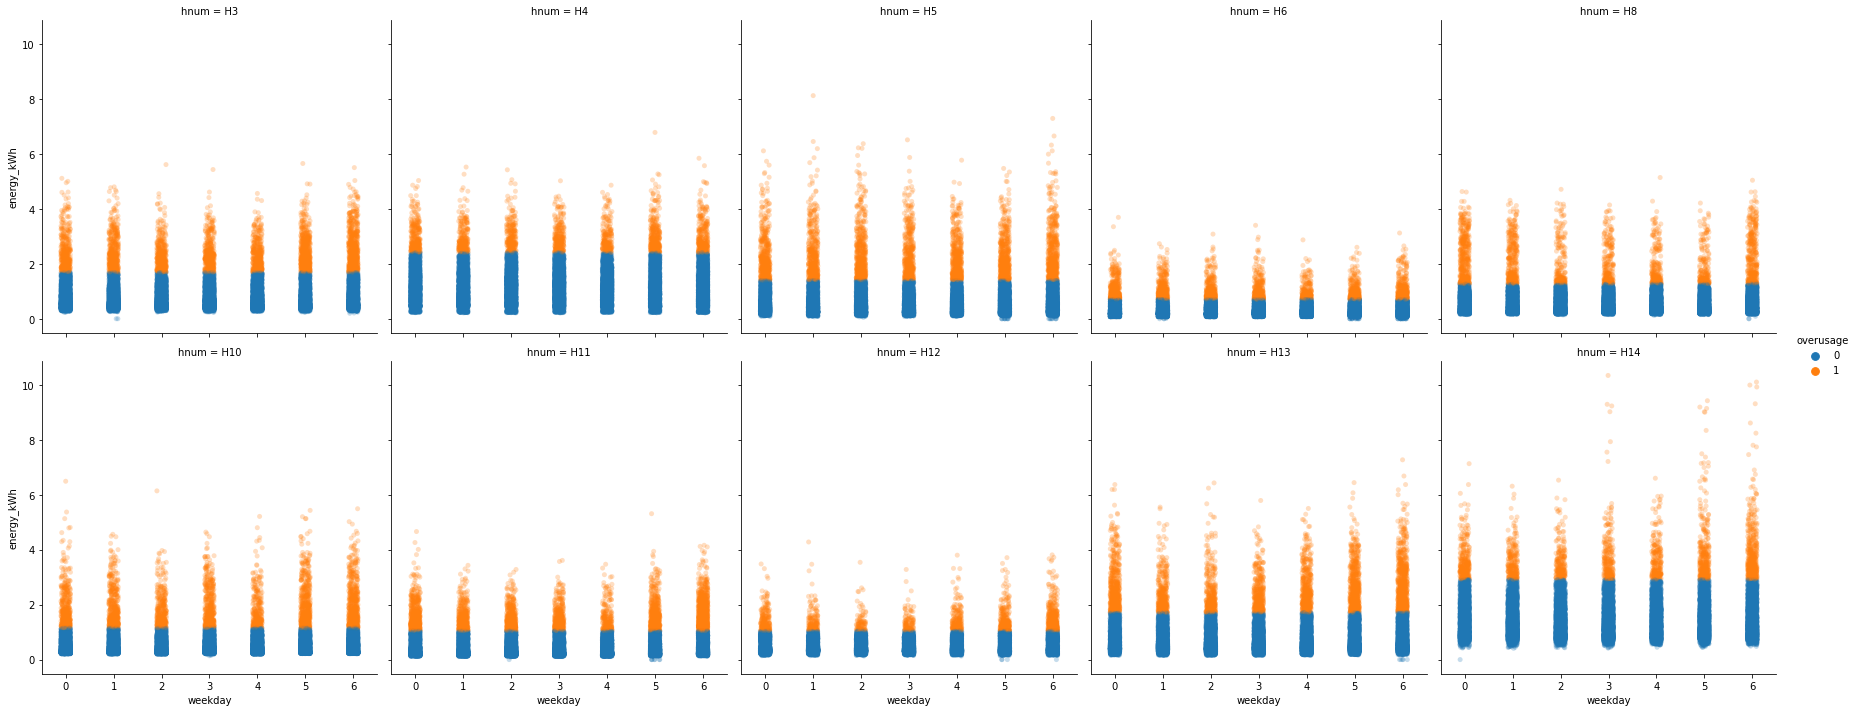

In [9]:
sns.catplot(x="weekday", y="energy_kWh",hue="overusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25);

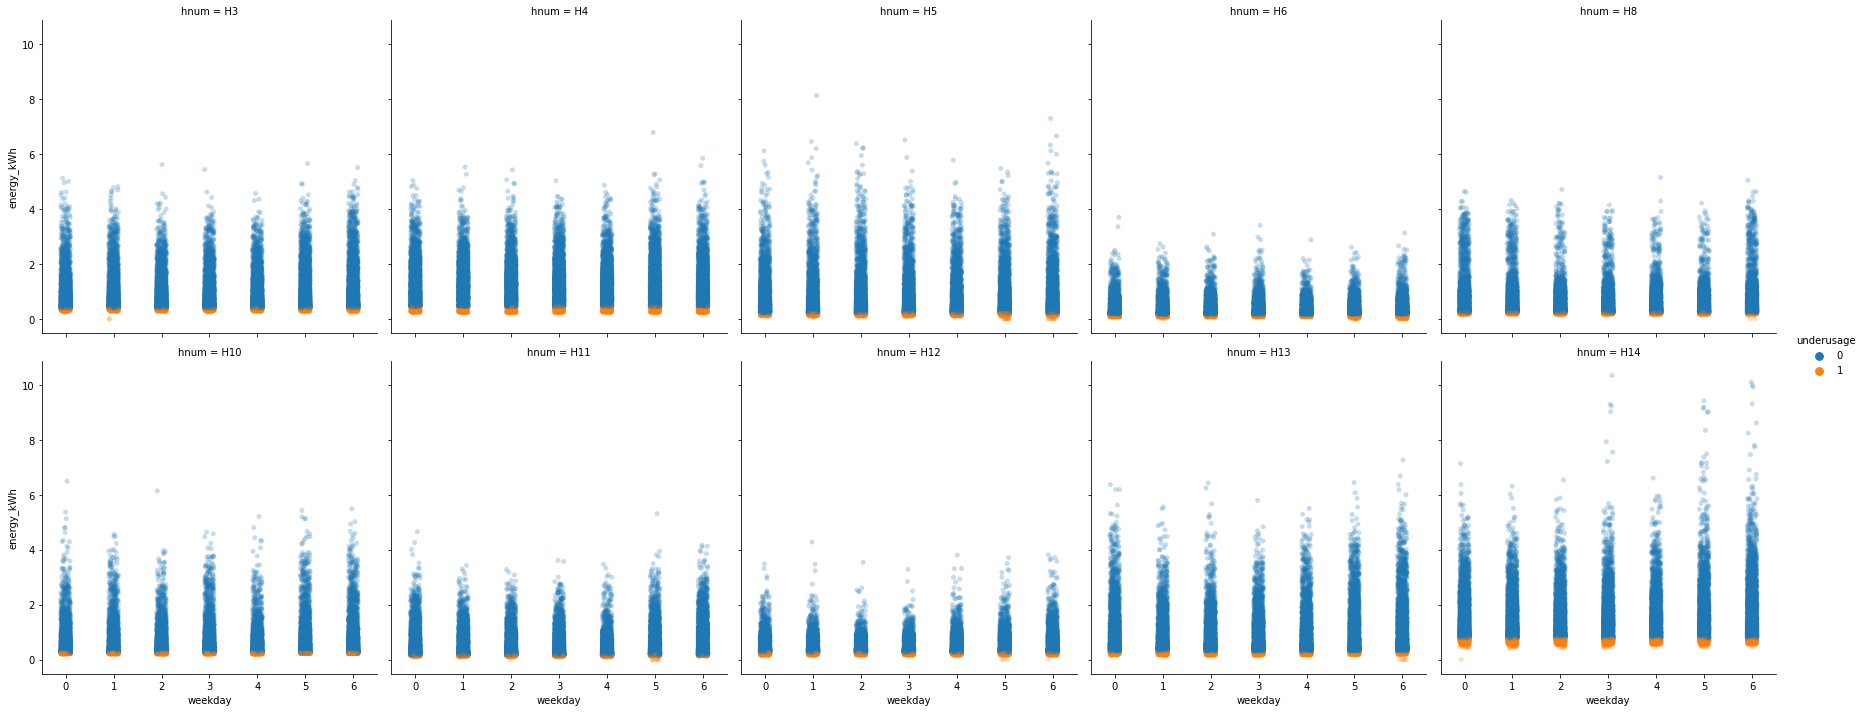

In [10]:
sns.catplot(x="weekday", y="energy_kWh",hue="underusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25);

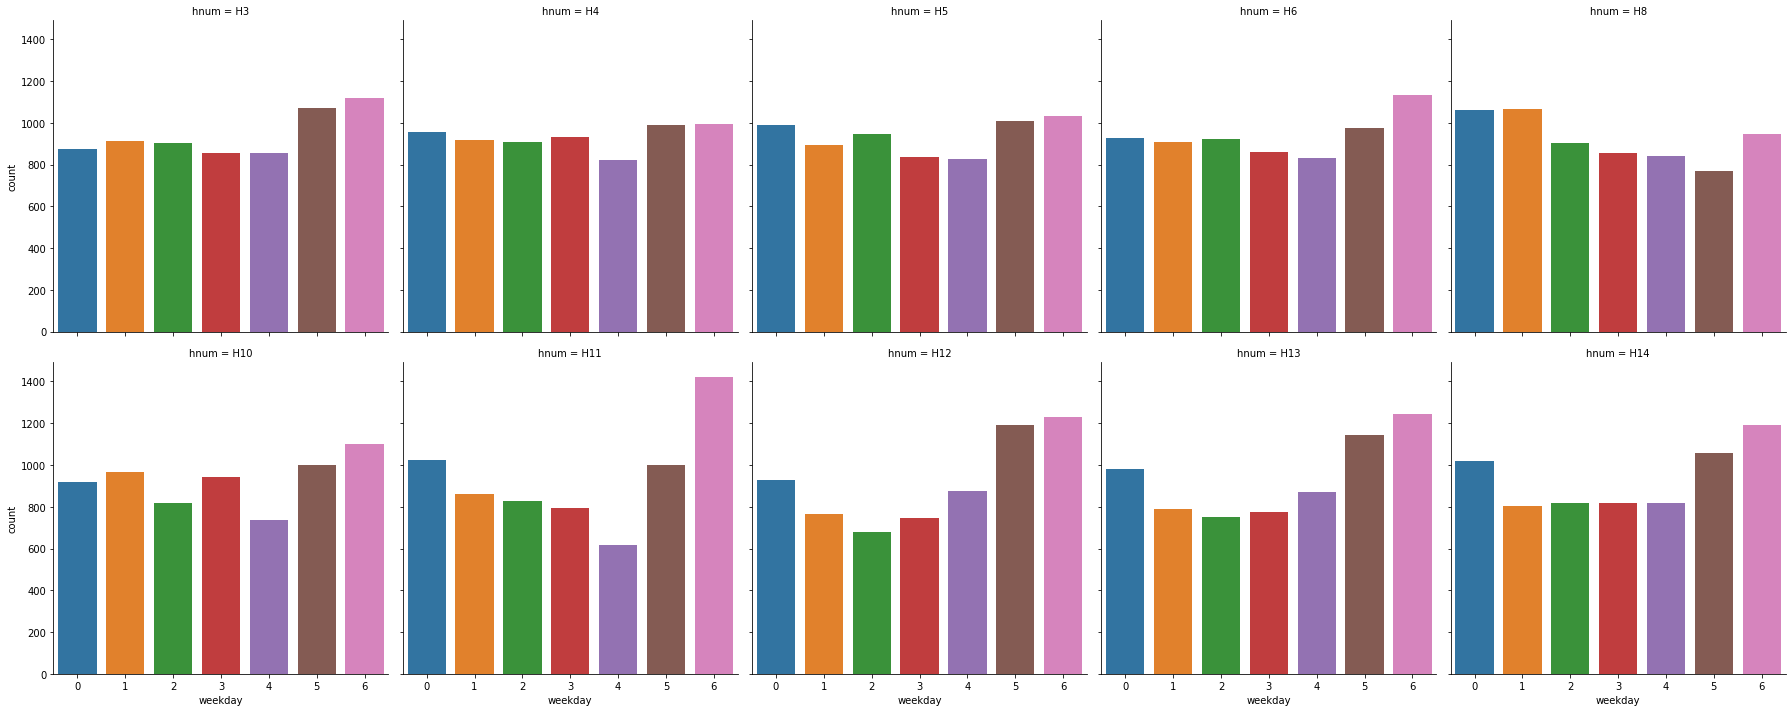

In [11]:
sns.catplot(x="weekday", col="hnum",data=all_data[all_data['overusage']==1], kind="count", col_wrap=5)

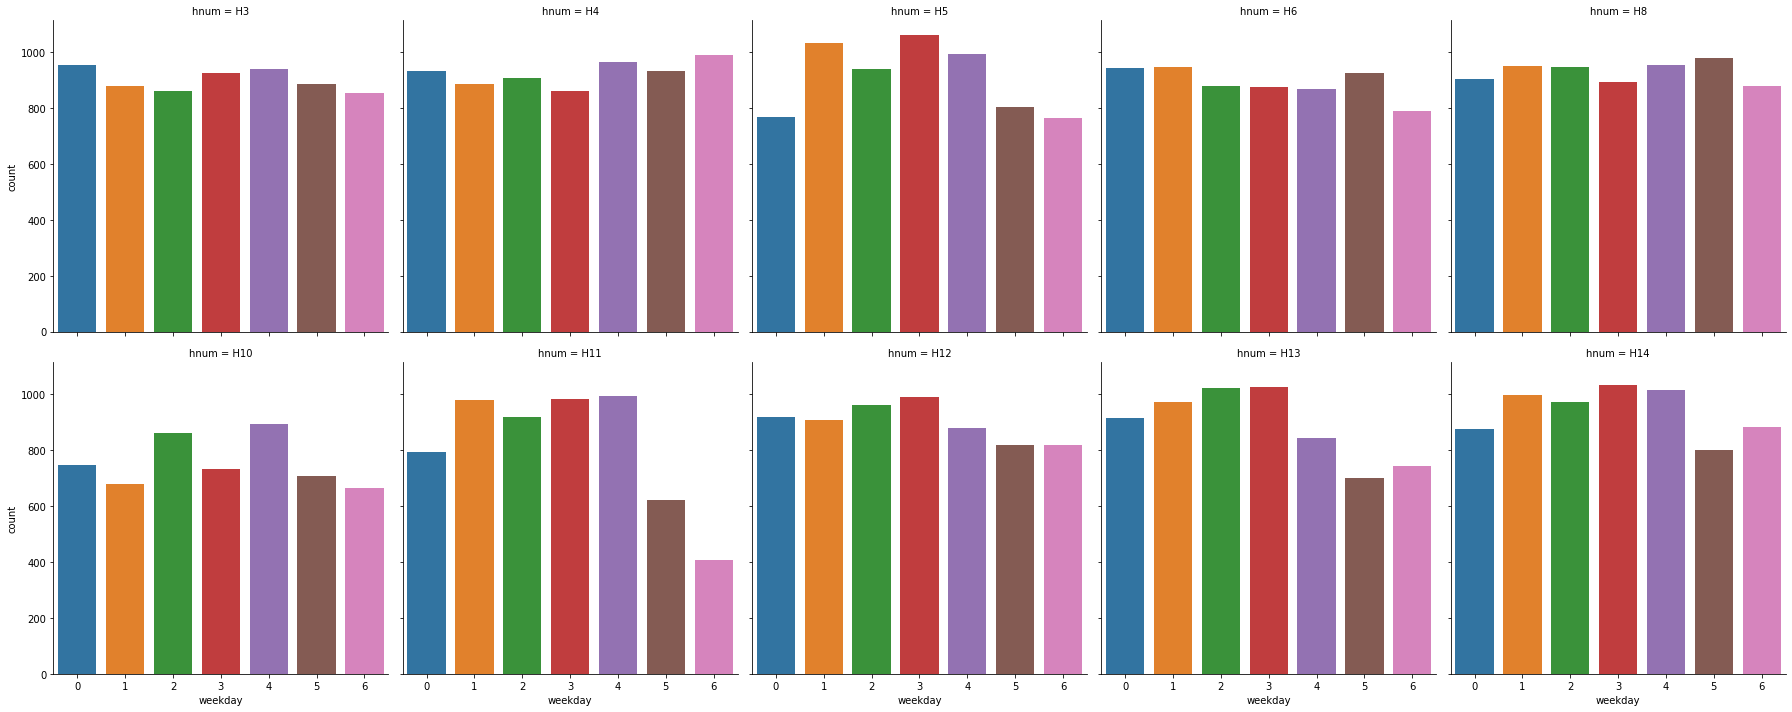

In [12]:
sns.catplot(x="weekday", col="hnum",data=all_data[all_data['underusage']==1], kind="count", col_wrap=5)

## Months

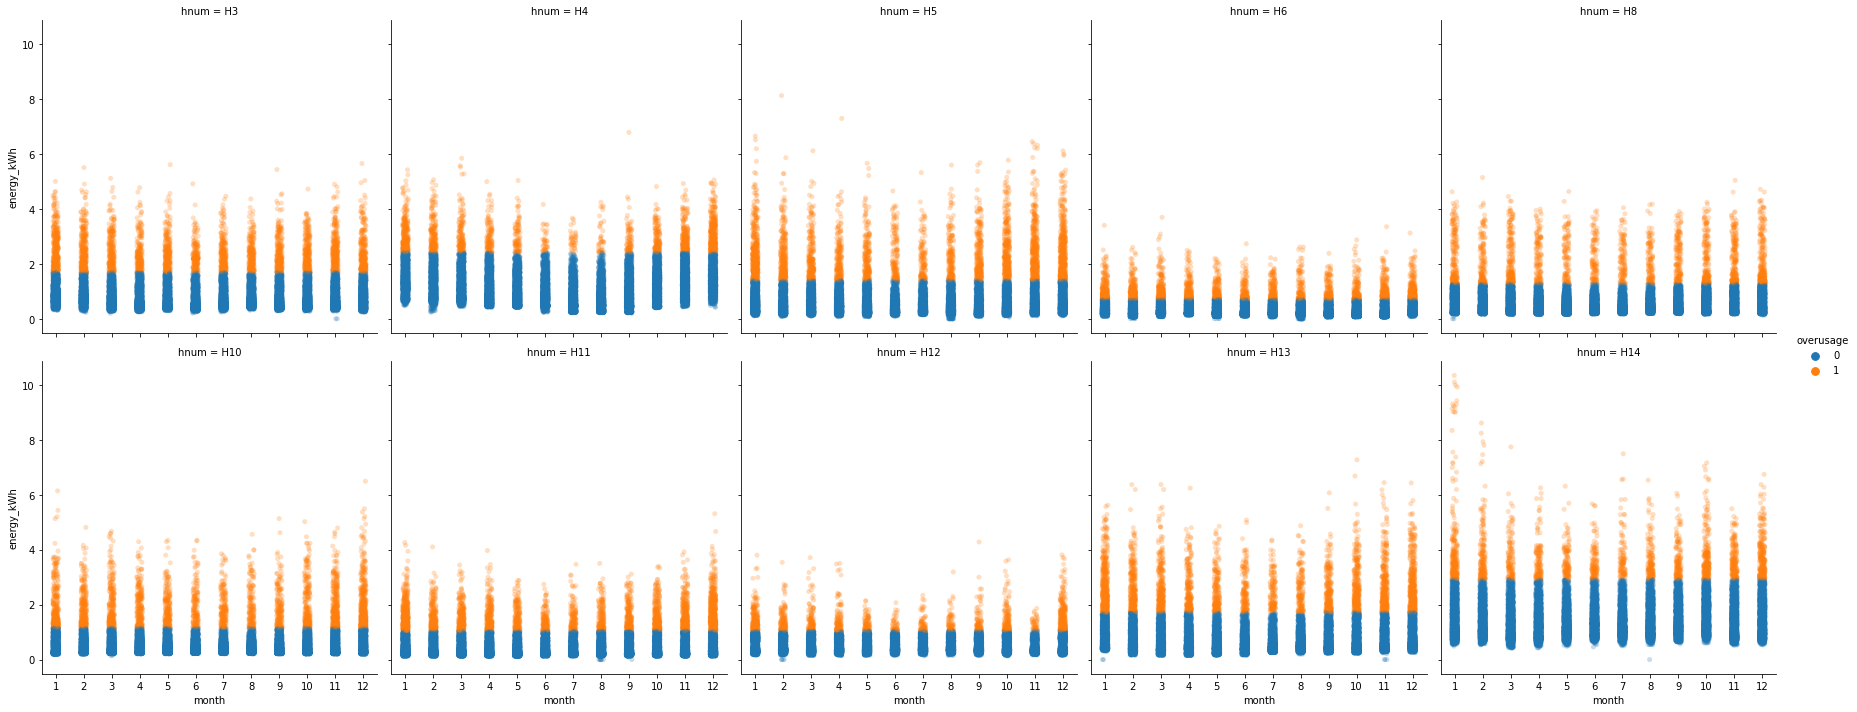

In [13]:
sns.catplot(x="month", y="energy_kWh",hue="overusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25);

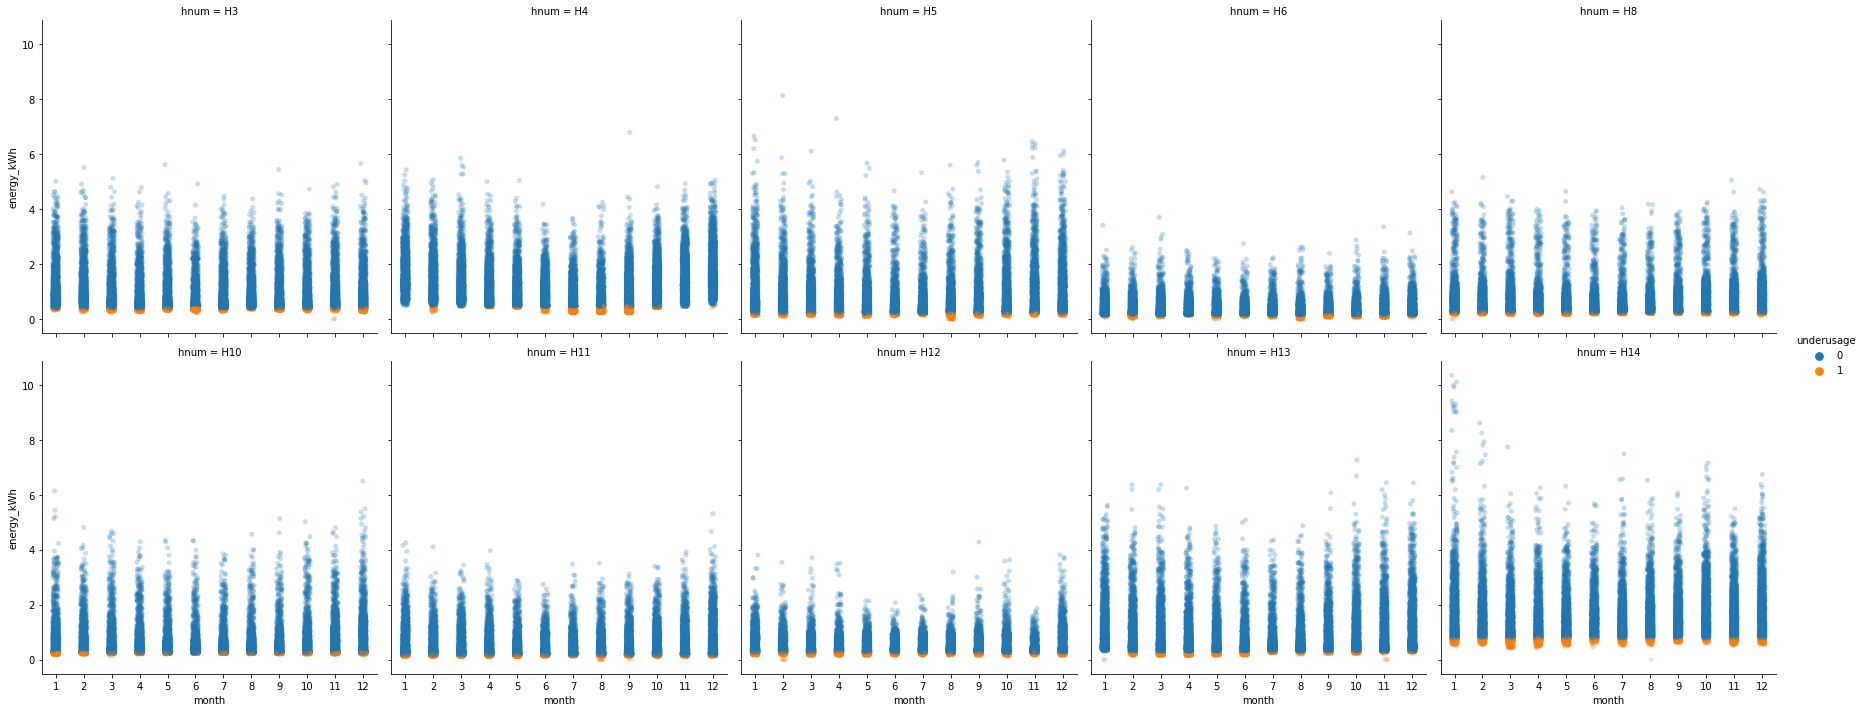

In [14]:
sns.catplot(x="month", y="energy_kWh",hue="underusage", col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25);

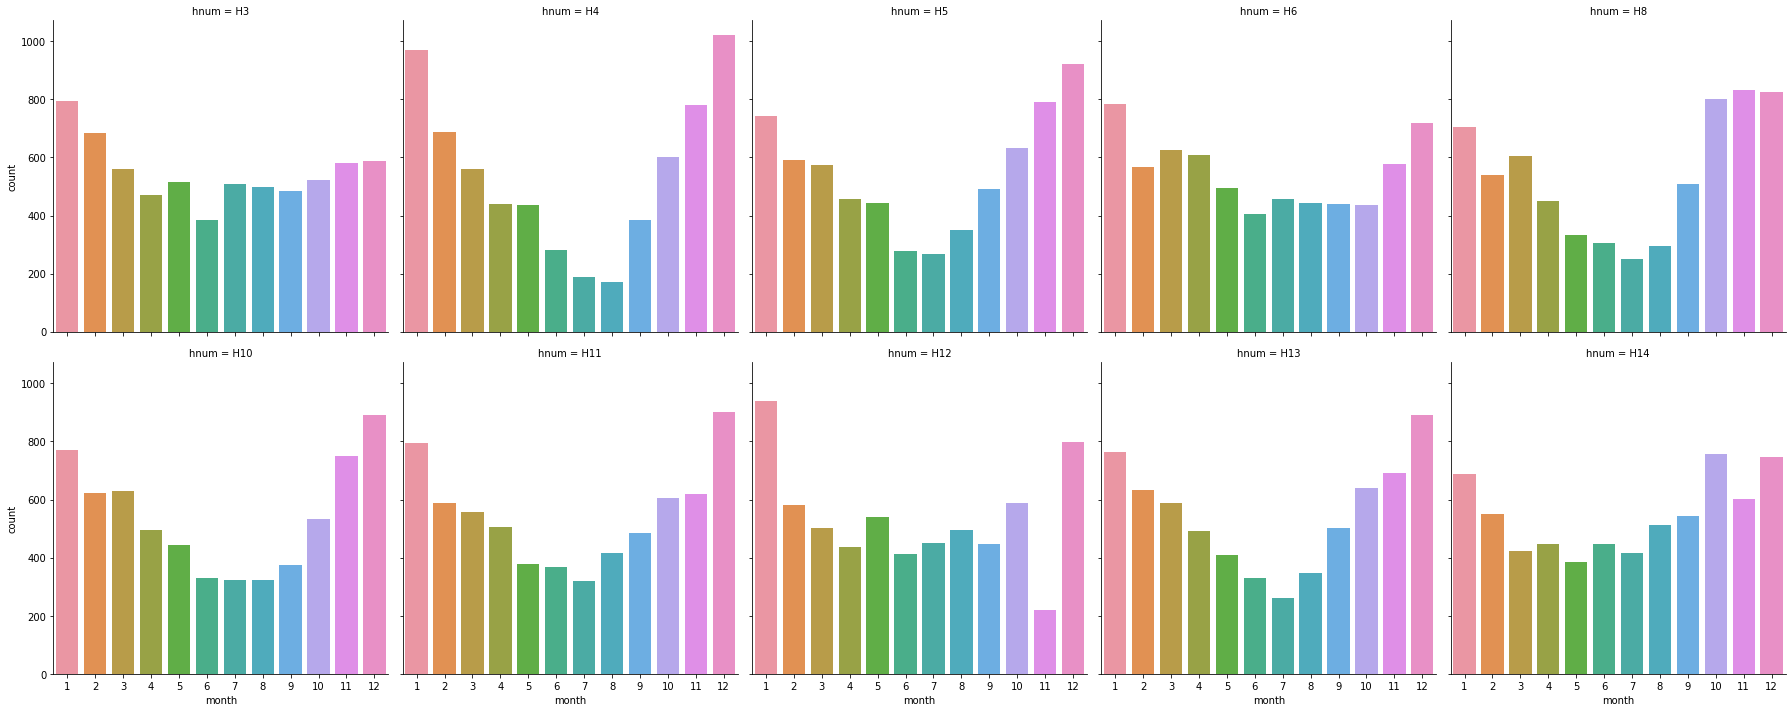

In [13]:
sns.catplot(x="month", col="hnum",data=all_data[all_data['overusage']==1], kind="count", col_wrap=5)

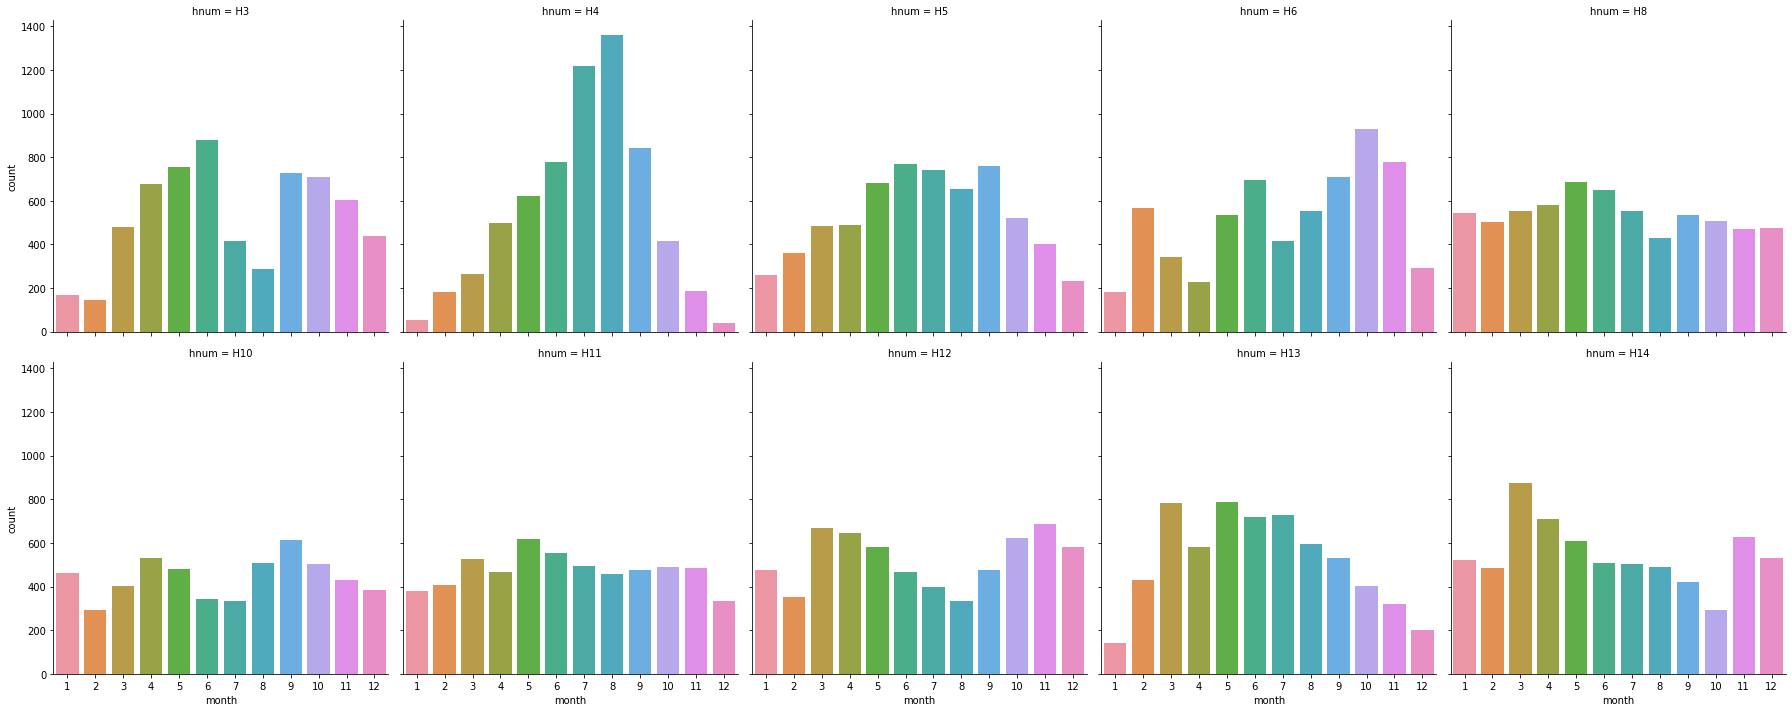

In [14]:
sns.catplot(x="month", col="hnum",data=all_data[all_data['underusage']==1], kind="count", col_wrap=5)

## Temperature

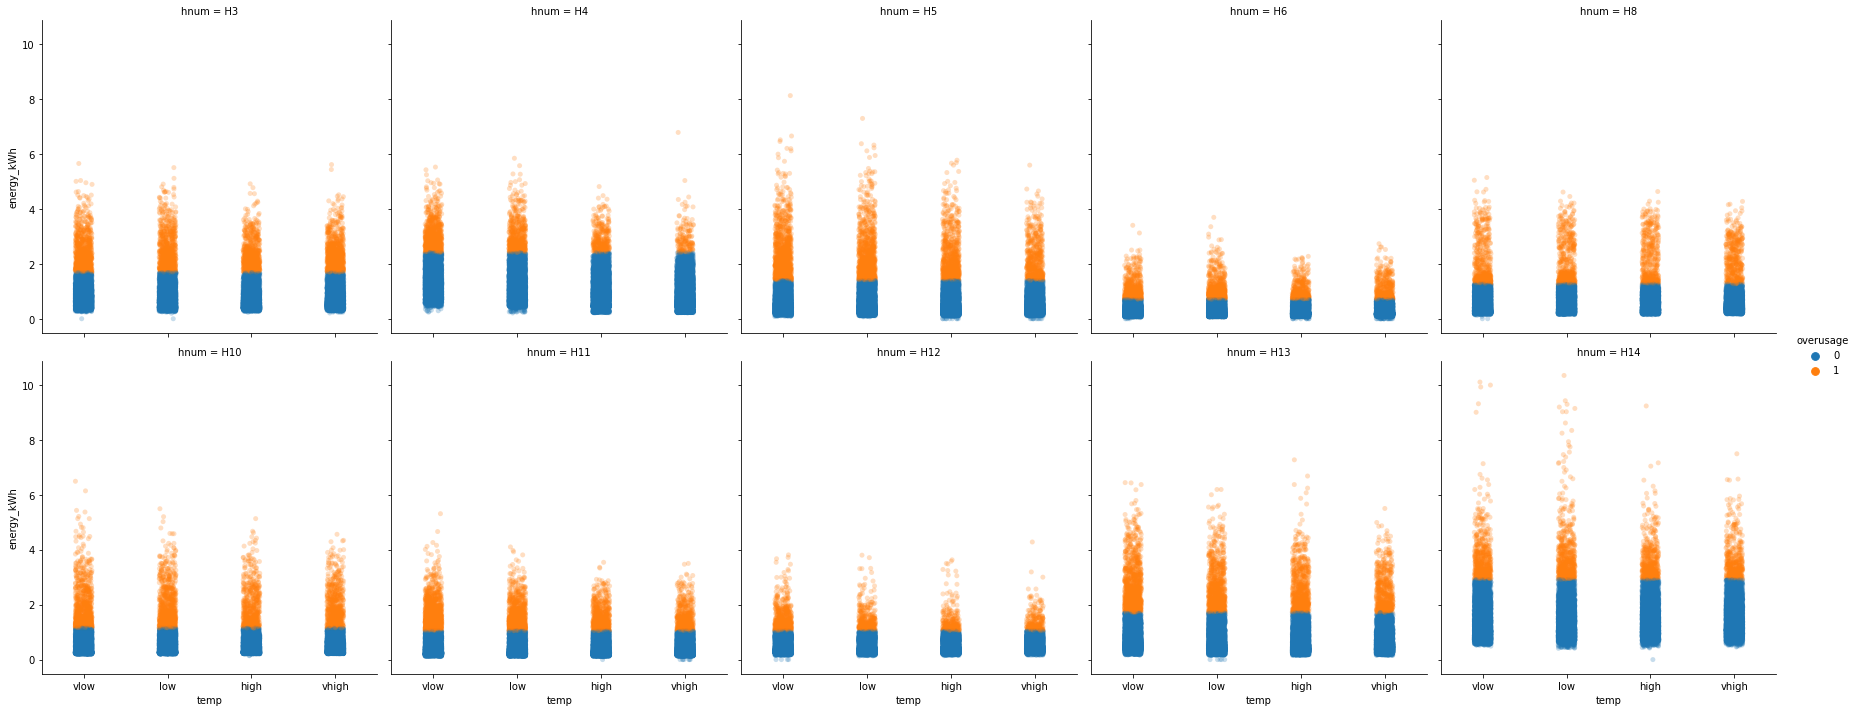

In [35]:
sns.catplot(x="temp", y="energy_kWh",hue="overusage",order=['vlow','low','high','vhigh'],col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25)

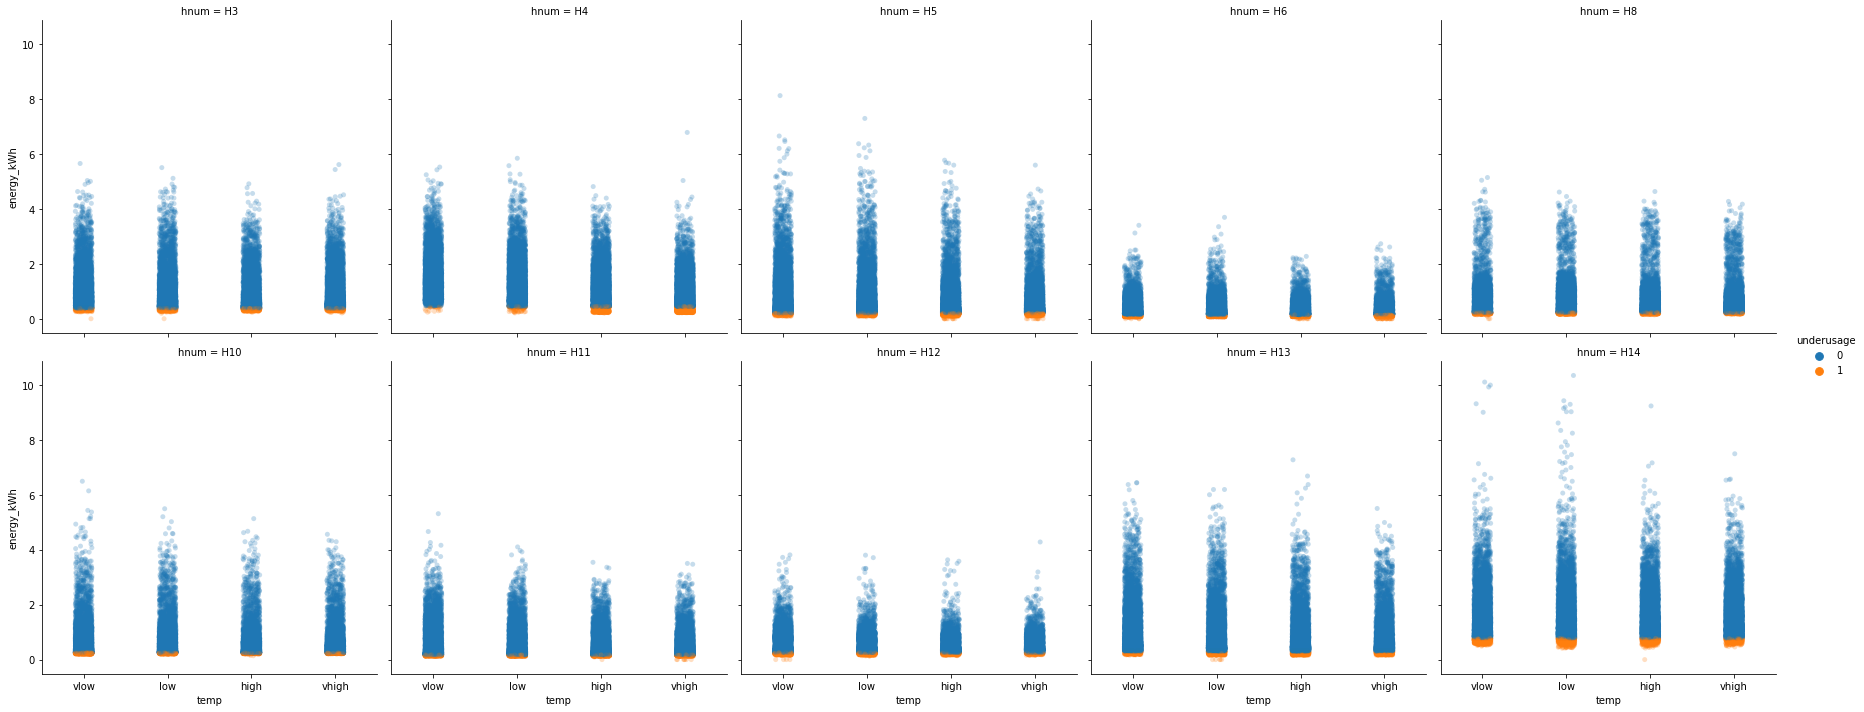

In [36]:
sns.catplot(x="temp", y="energy_kWh",hue="underusage",order=['vlow','low','high','vhigh'],col="hnum",data=all_data, kind="strip", col_wrap=5,alpha=0.25)

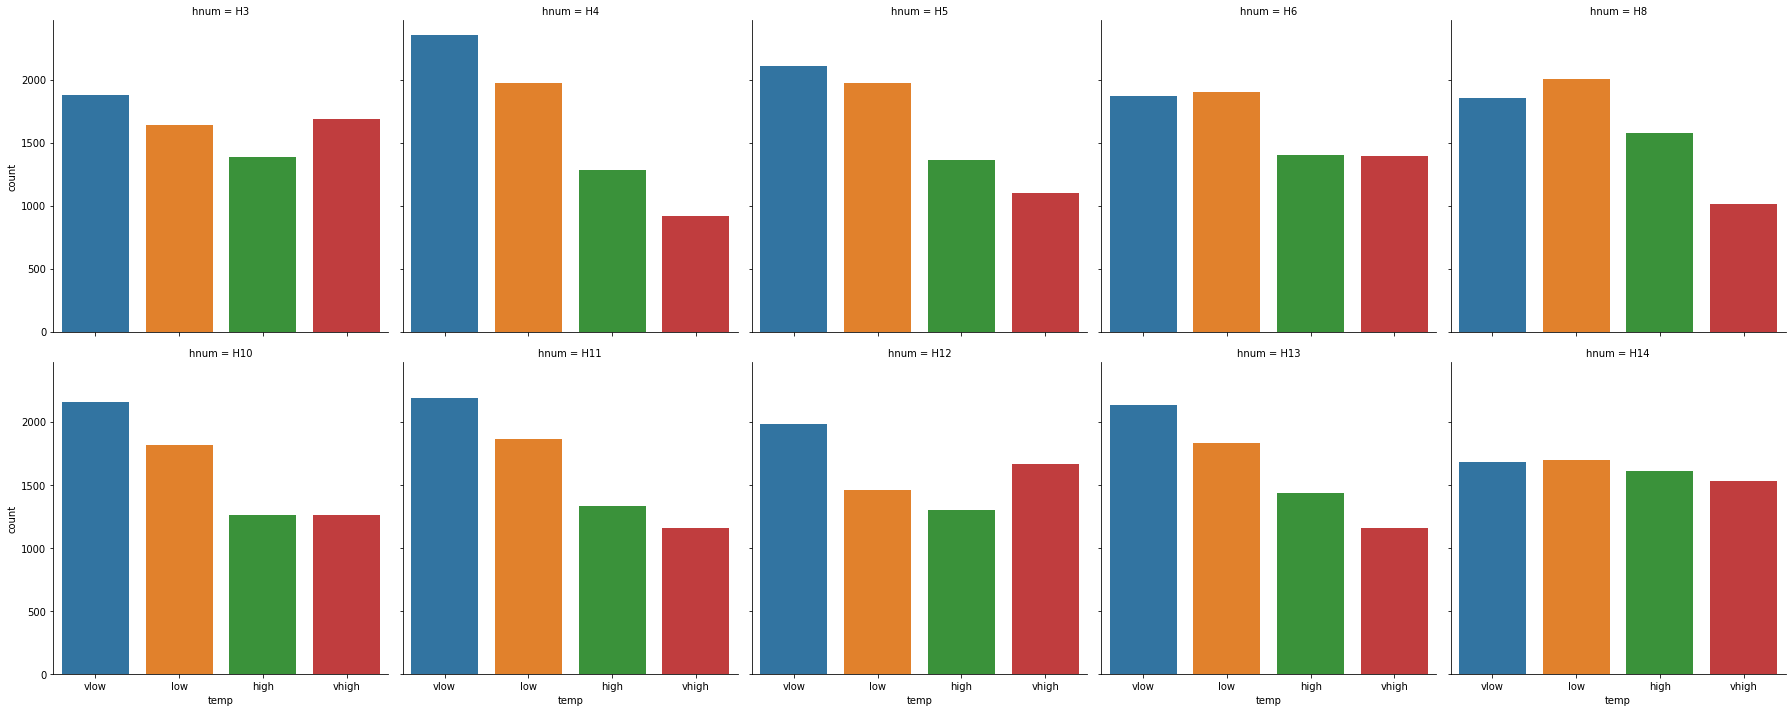

In [17]:
sns.catplot(x="temp", col="hnum",data=all_data[all_data['overusage']==1],order=['vlow','low','high','vhigh'] ,kind="count", col_wrap=5)

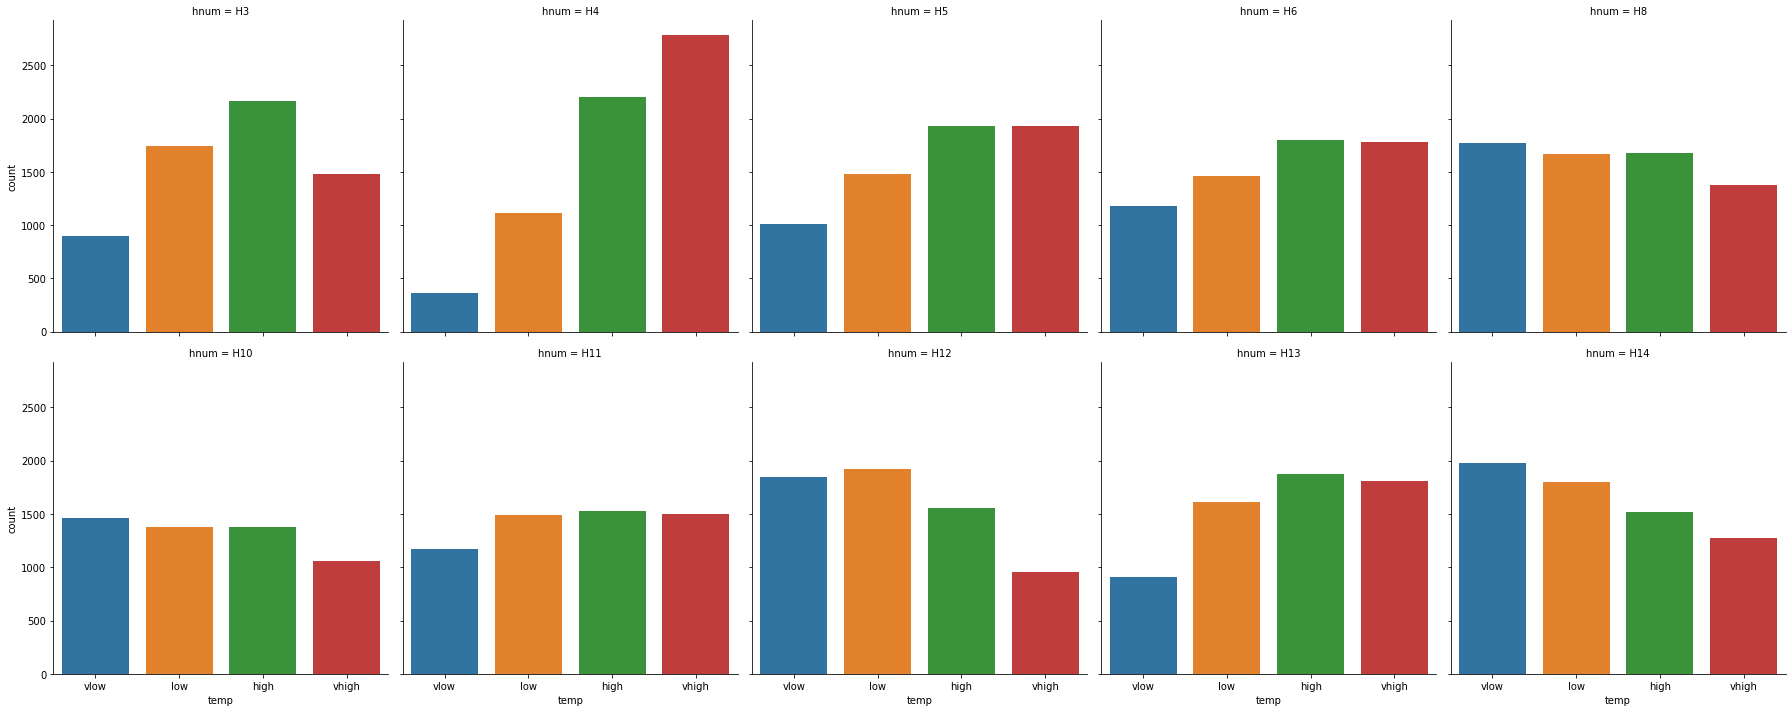

In [18]:
sns.catplot(x="temp", col="hnum",data=all_data[all_data['underusage']==1],order=['vlow','low','high','vhigh'] ,kind="count", col_wrap=5)

## Humidity

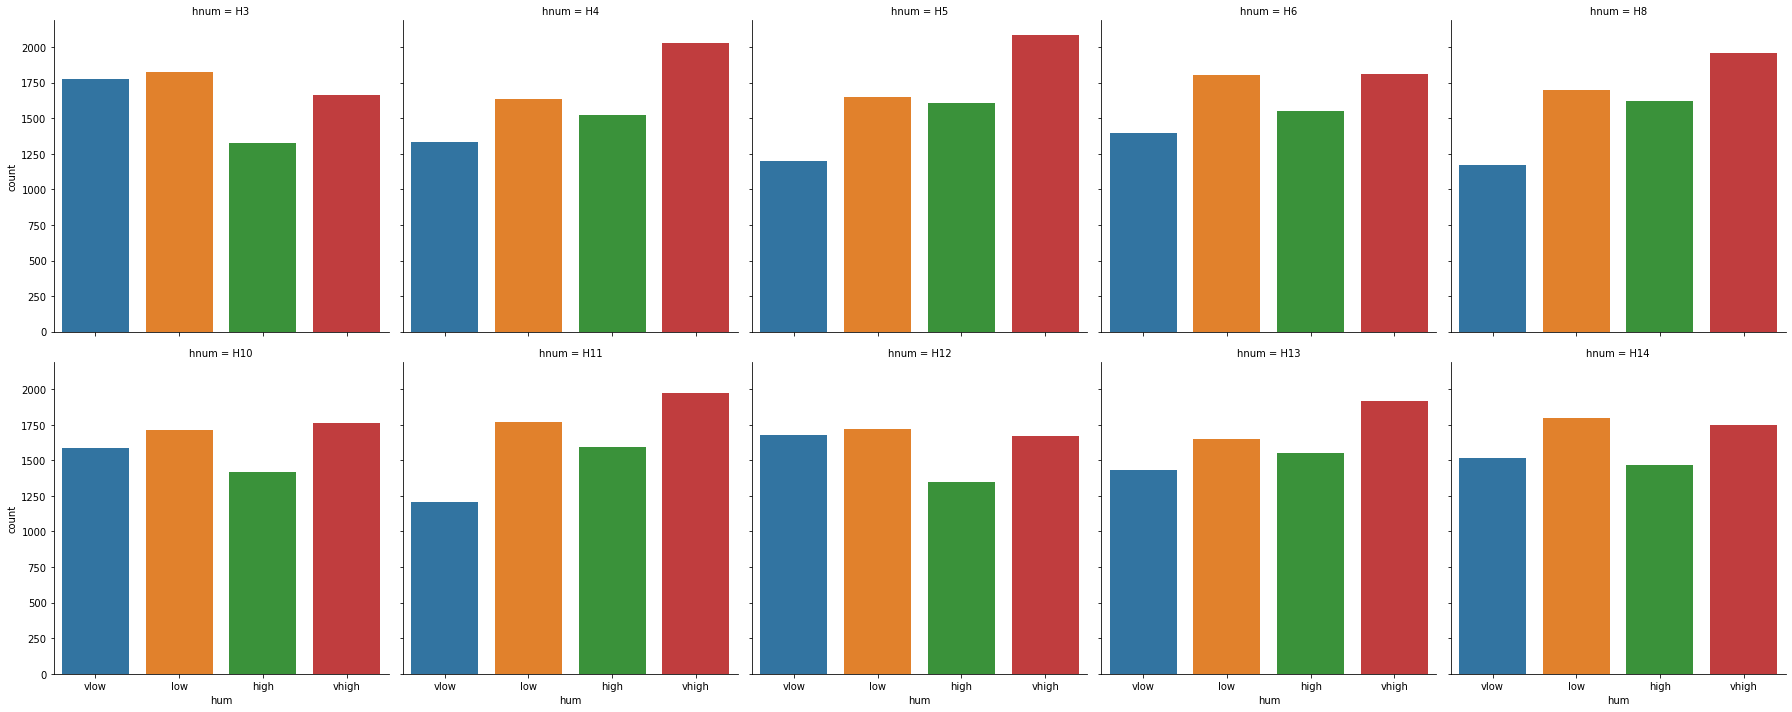

In [10]:
sns.catplot(x="hum", col="hnum",data=all_data[all_data['overusage']==1],order=['vlow','low','high','vhigh'] ,kind="count", col_wrap=5)

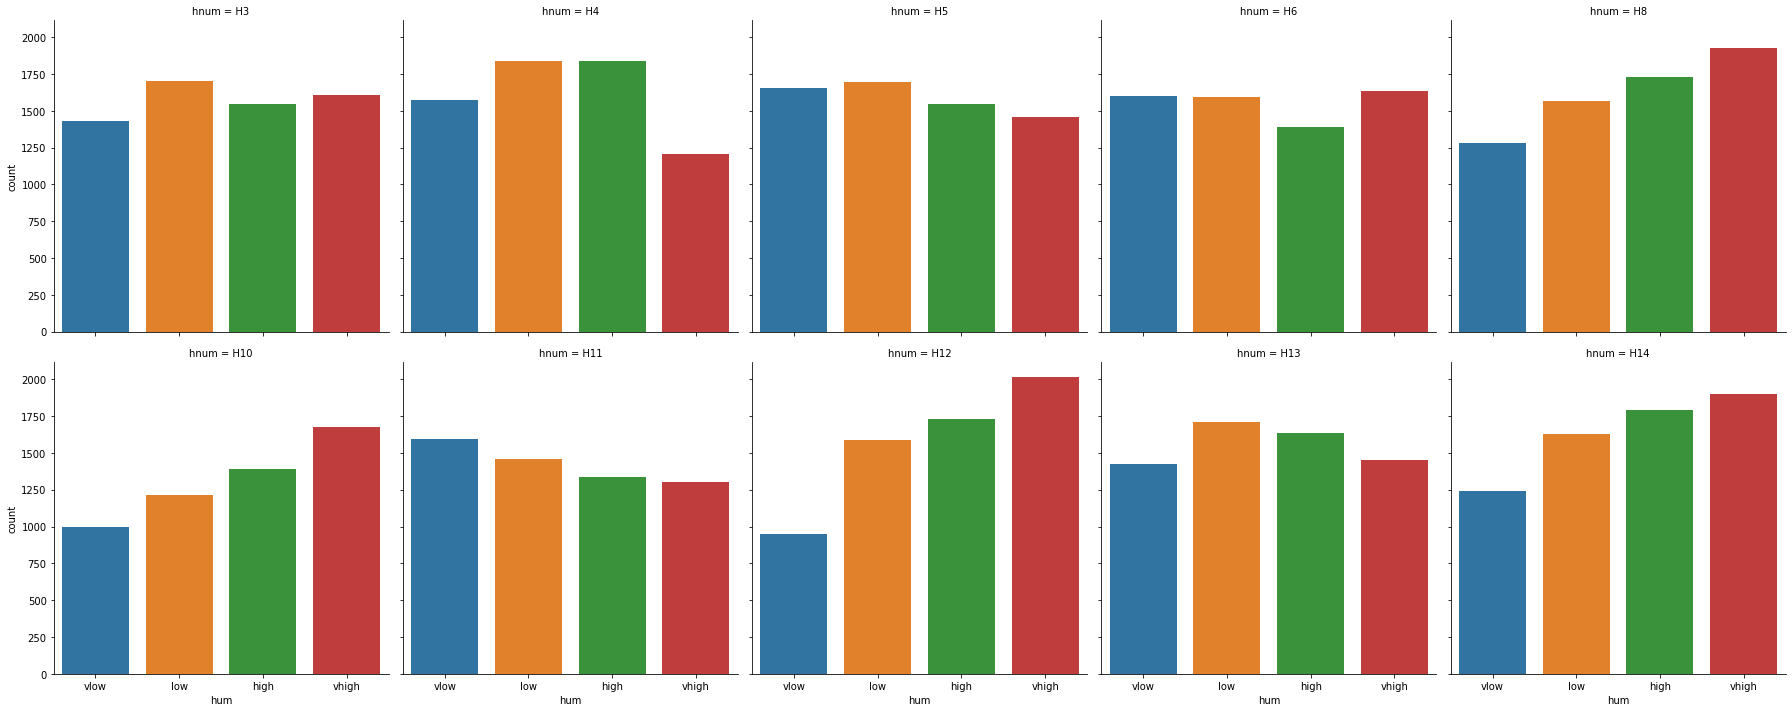

In [11]:
sns.catplot(x="hum", col="hnum",data=all_data[all_data['underusage']==1],order=['vlow','low','high','vhigh'] ,kind="count", col_wrap=5)

## Facing and Type

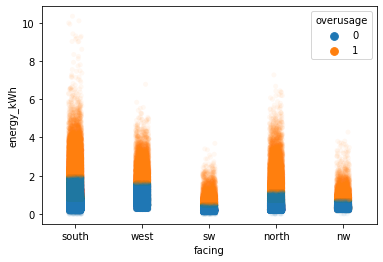

In [17]:
sns.stripplot(x="facing", y="energy_kWh",hue="overusage",data=all_data,alpha=0.05)

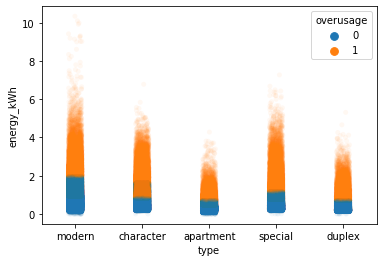

In [16]:
sns.stripplot(x="type", y="energy_kWh",hue="overusage",data=all_data,alpha=0.05)

# 2. Trends and Sesonality

##H3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbccbb68b50>,
      dtype=object)

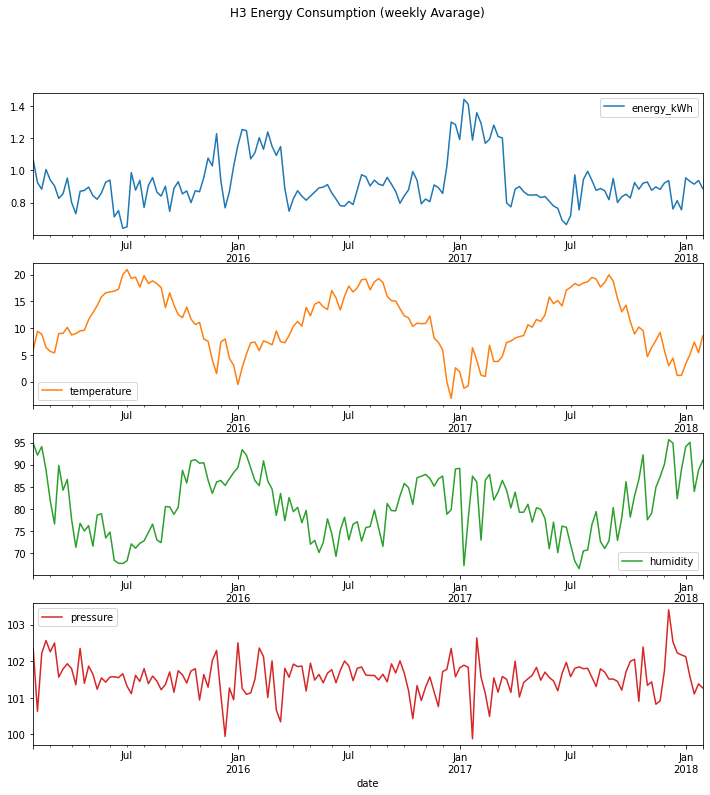

In [11]:

hdata= all_data[all_data['hnum']=='H3'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H3 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)


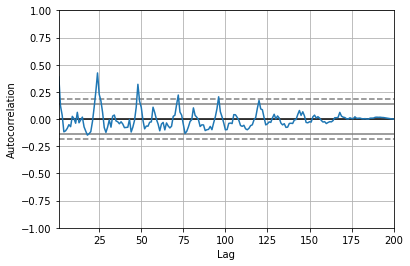

In [27]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

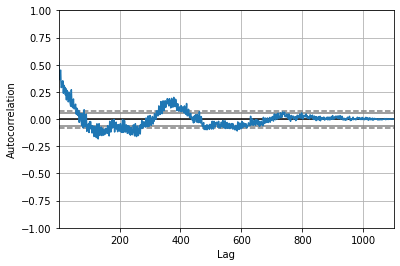

In [35]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

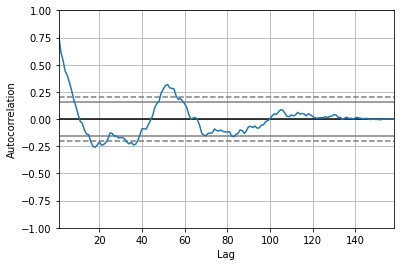

In [30]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

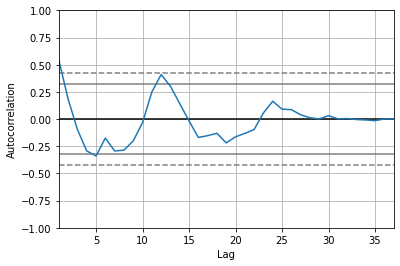

In [31]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

##H4

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcc8af4650>,
      dtype=object)

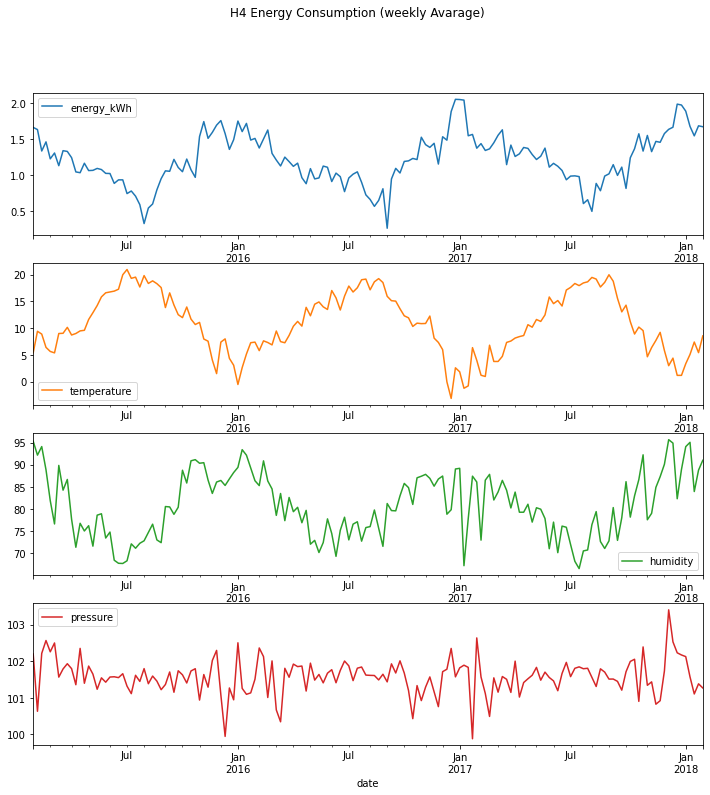

In [38]:
hdata= all_data[all_data['hnum']=='H4'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H4 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

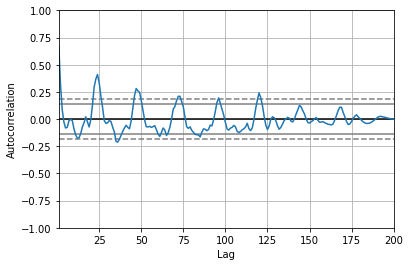

In [37]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

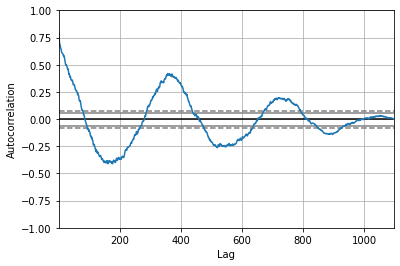

In [39]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

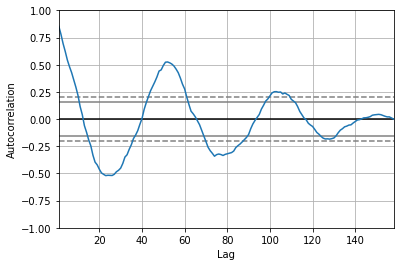

In [40]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

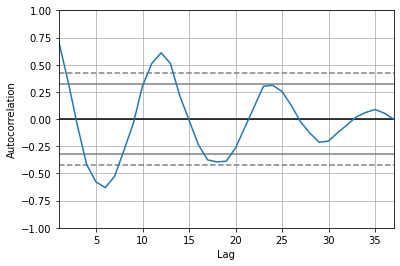

In [41]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

##H5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd40acf1b90>,
      dtype=object)

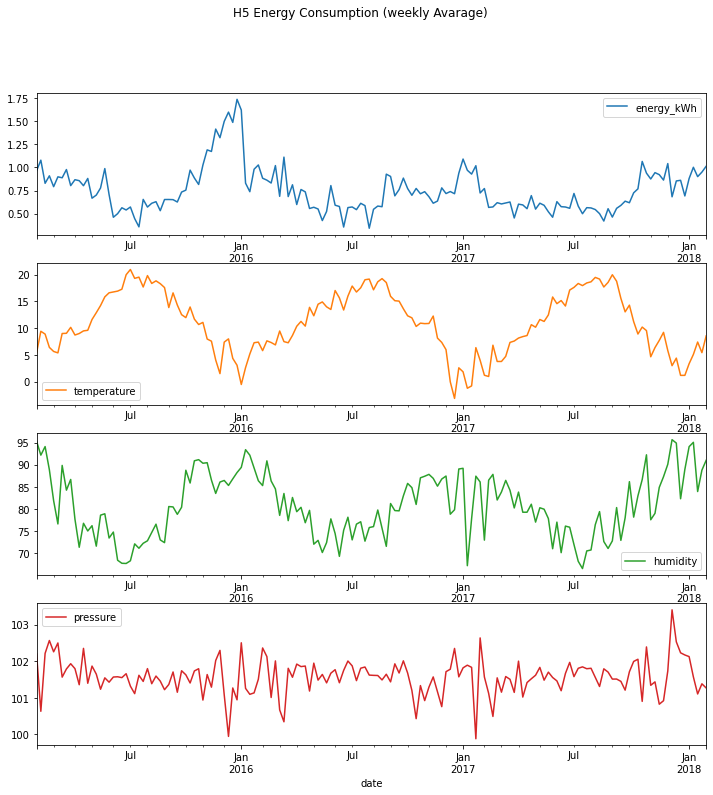

In [4]:
hdata= all_data[all_data['hnum']=='H5'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H5 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

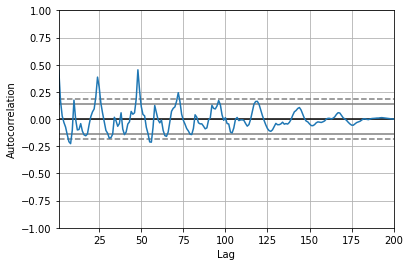

In [5]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

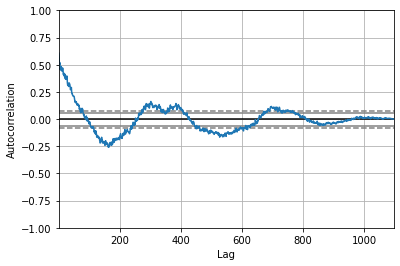

In [6]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

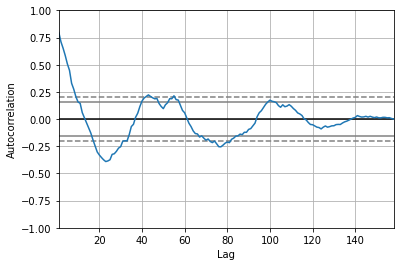

In [7]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

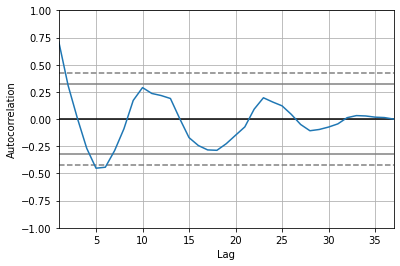

In [8]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

##H6

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4062d3b50>,
      dtype=object)

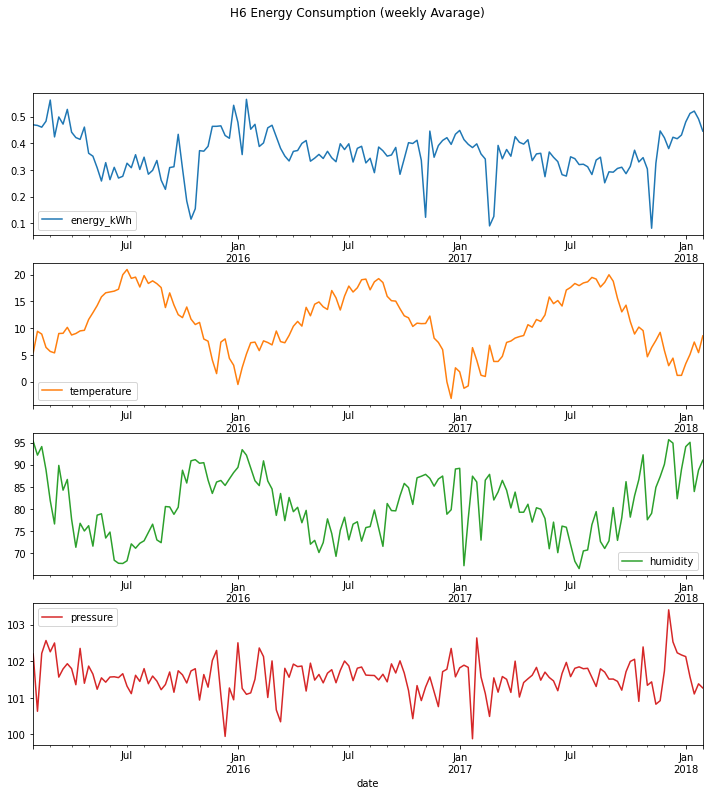

In [9]:
hdata= all_data[all_data['hnum']=='H6'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H6 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

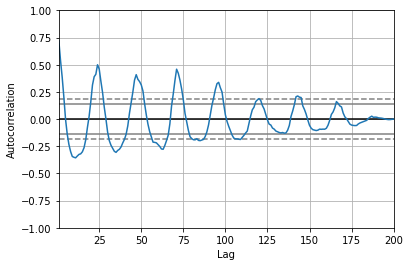

In [10]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

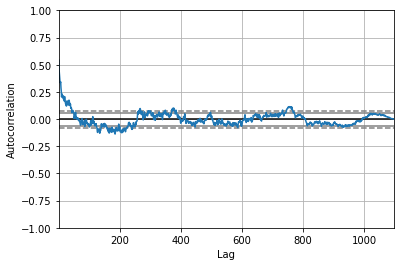

In [11]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

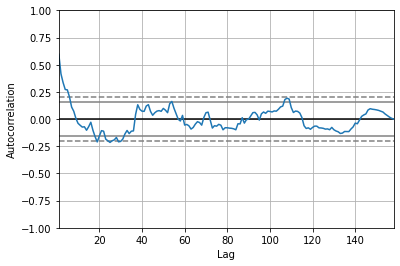

In [12]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

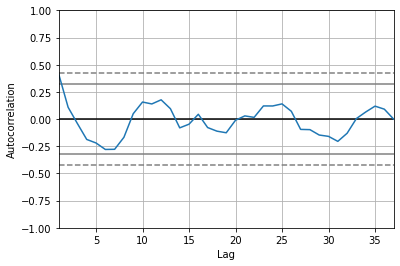

In [13]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H8

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd405c6bd50>,
      dtype=object)

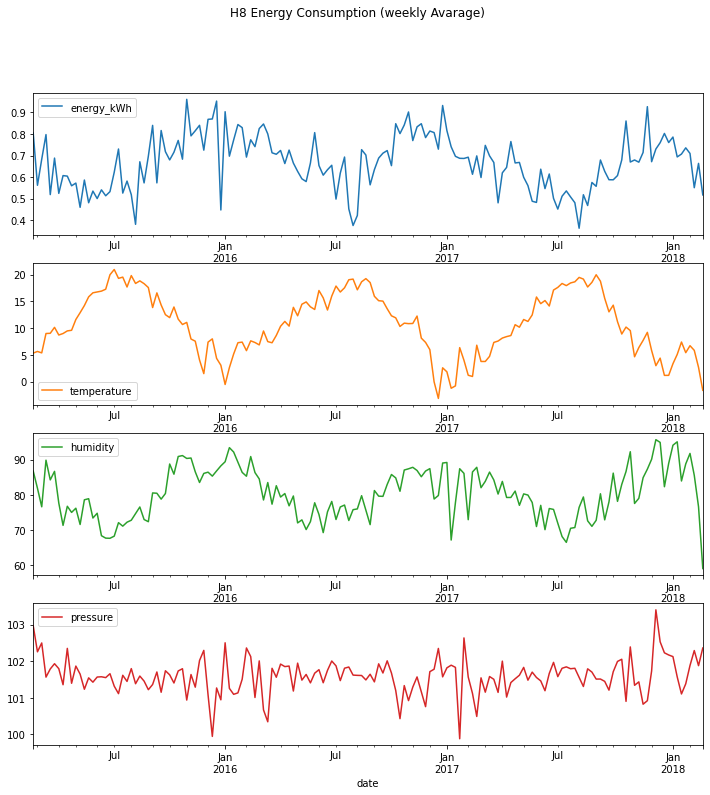

In [14]:
hdata= all_data[all_data['hnum']=='H8'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H8 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

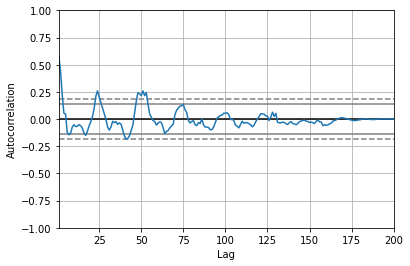

In [15]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

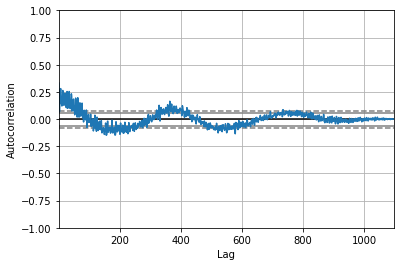

In [16]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

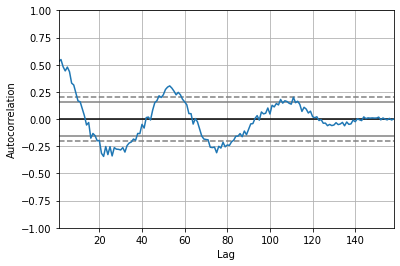

In [17]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

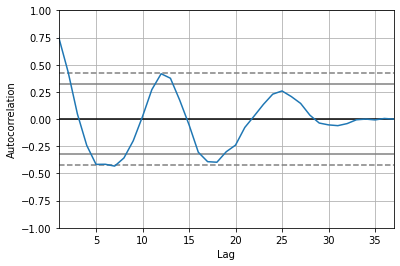

In [18]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H10

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd40573dd10>,
      dtype=object)

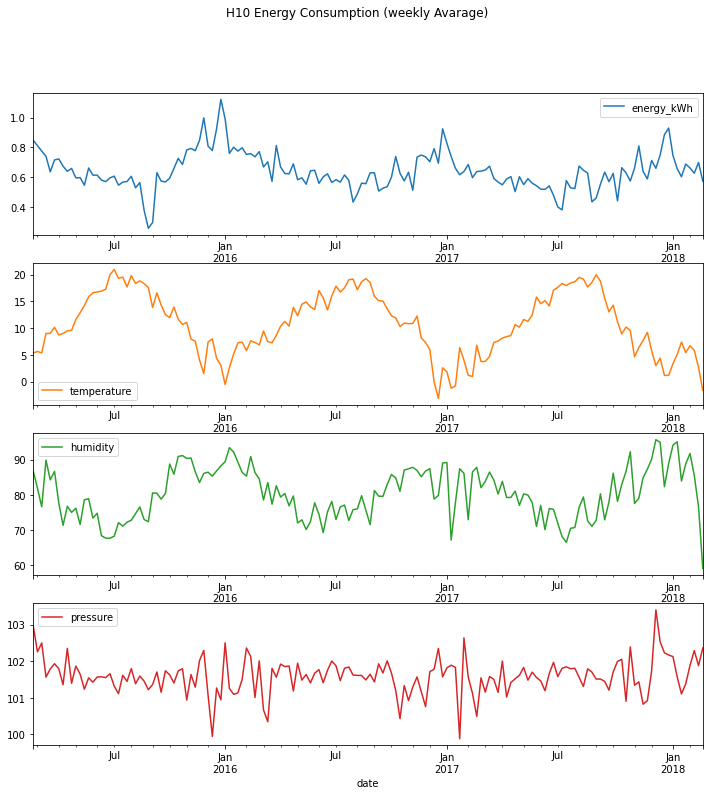

In [19]:
hdata= all_data[all_data['hnum']=='H10'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H10 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

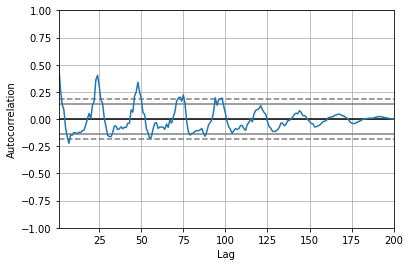

In [20]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

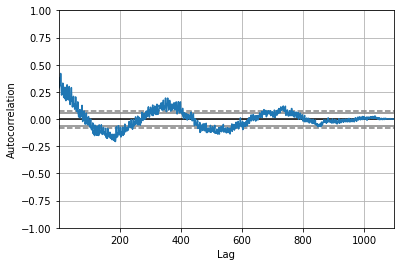

In [21]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

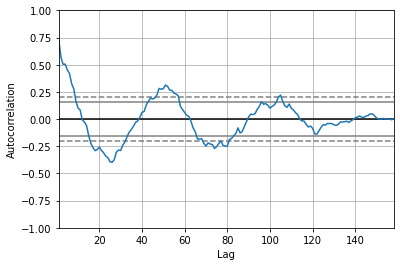

In [22]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

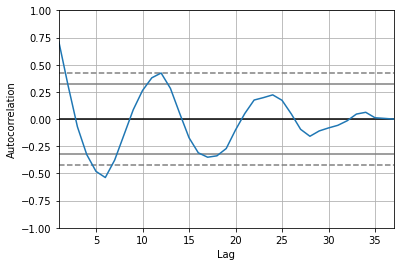

In [23]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H11

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd405251290>,
      dtype=object)

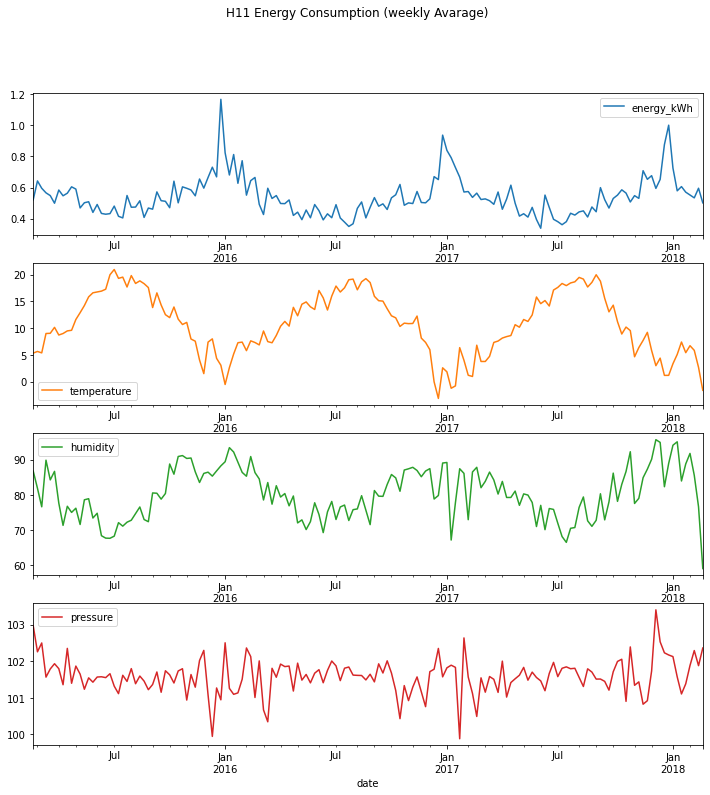

In [24]:
hdata= all_data[all_data['hnum']=='H11'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H11 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

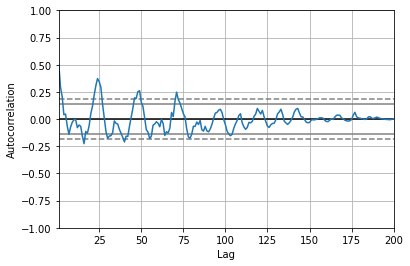

In [25]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

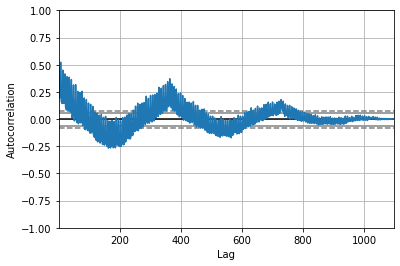

In [26]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

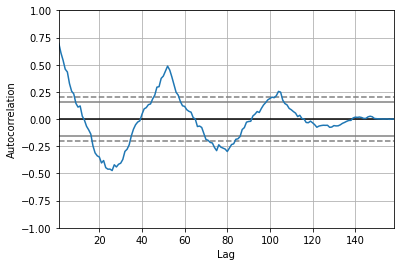

In [27]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

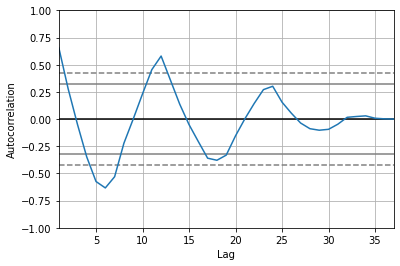

In [28]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H12

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd404d0bd50>,
      dtype=object)

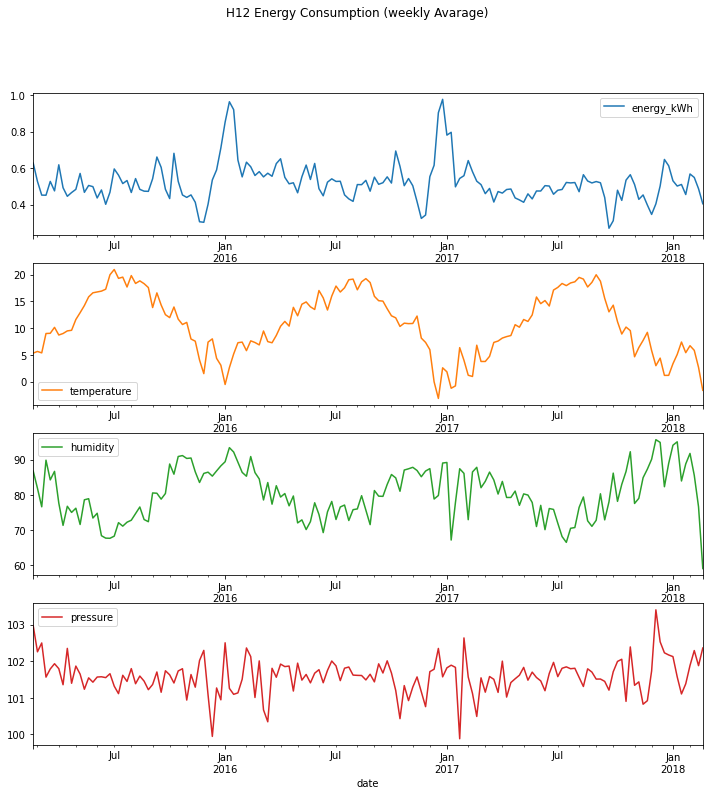

In [29]:
hdata= all_data[all_data['hnum']=='H12'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H12 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

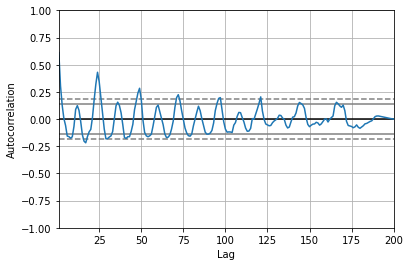

In [30]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

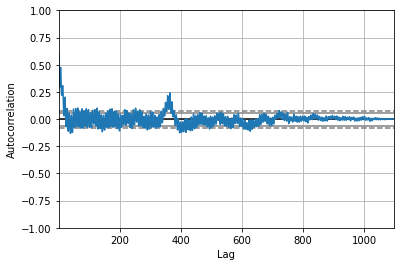

In [31]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

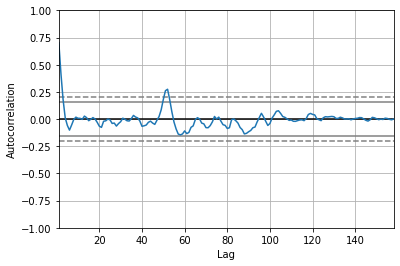

In [32]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

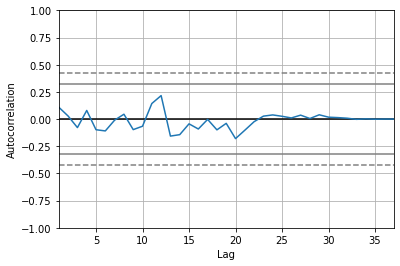

In [33]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H13

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd40481d490>,
      dtype=object)

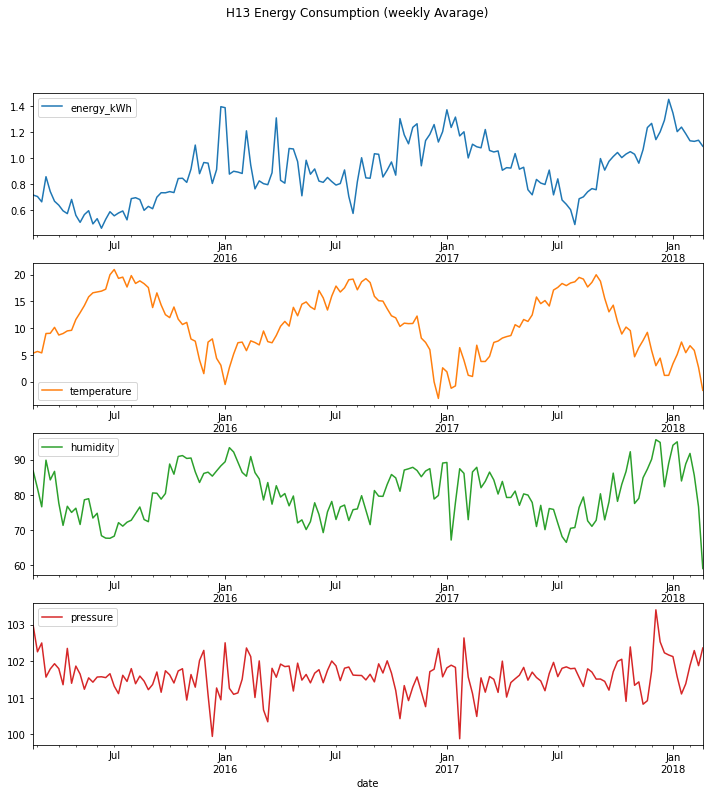

In [34]:
hdata= all_data[all_data['hnum']=='H13'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H13 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

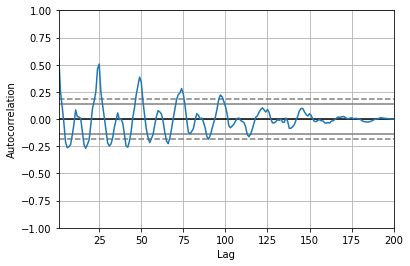

In [35]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

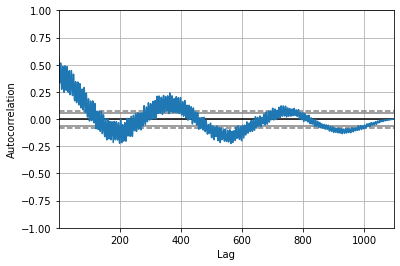

In [36]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

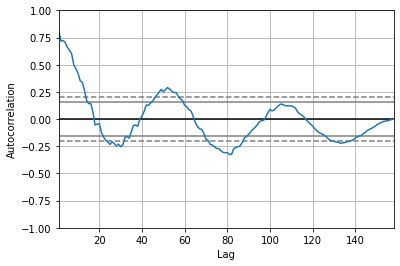

In [37]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

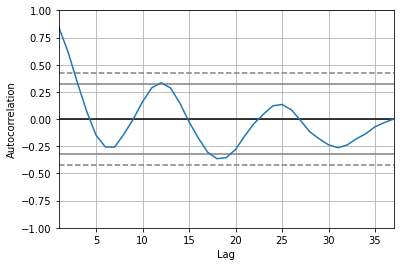

In [38]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

## H14

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4042c9d50>,
      dtype=object)

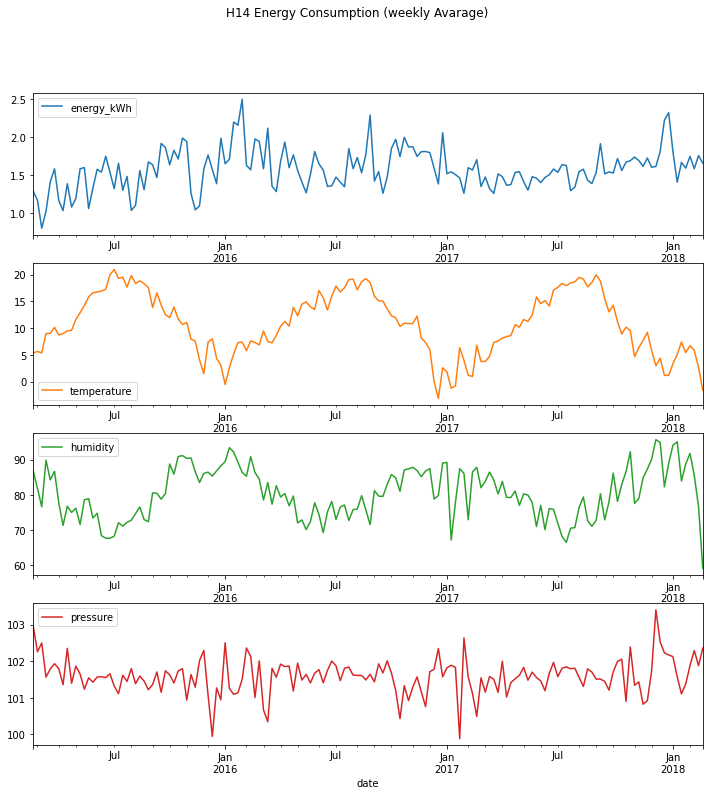

In [39]:
hdata= all_data[all_data['hnum']=='H14'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H14 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)

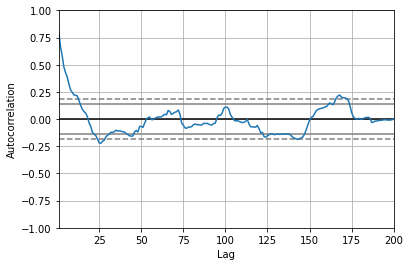

In [40]:
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])

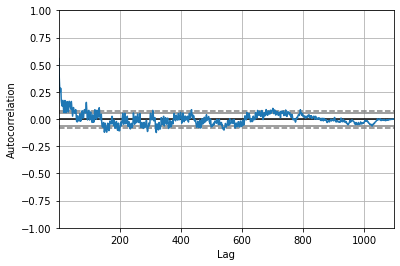

In [41]:
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())

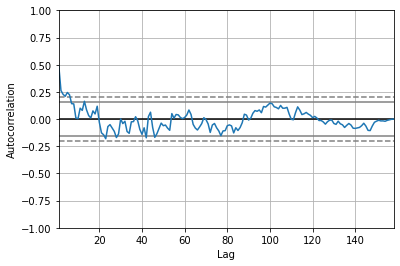

In [42]:
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())

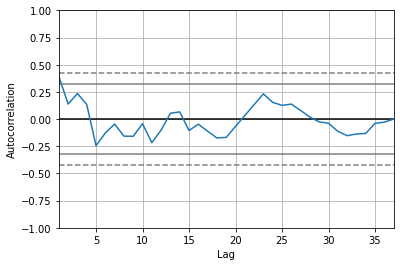

In [43]:
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

In [ ]:
hnum =['H3','H4','H5','H6','H8','H10','H11','H12','H13','H14']
hdata= all_data[all_data['hnum']=='H3'][['date','energy_kWh','temperature','humidity','pressure']]
hdata= hdata.set_index('date')
hdata.resample('W').mean().plot(subplots=True,title="H3 Energy Consumption (weekly Avarage)",figsize=(12,12),sharex=False)
#hourly 
pd.plotting.autocorrelation_plot(hdata['energy_kWh'][:200])
#daily
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('d').mean())
#weekly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('w').mean())
#monthly
pd.plotting.autocorrelation_plot(hdata['energy_kWh'].resample('m').mean())

# 3. Forcasting

## Stationarity Test

In [91]:
ts = all_data[all_data['hnum']=='H3']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [92]:
ts = all_data[all_data['hnum']=='H4']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [94]:
ts = all_data[all_data['hnum']=='H5']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [97]:
ts = all_data[all_data['hnum']=='H6']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [98]:
ts = all_data[all_data['hnum']=='H8']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [100]:
ts = all_data[all_data['hnum']=='H10']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [101]:
ts = all_data[all_data['hnum']=='H11']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [102]:
ts = all_data[all_data['hnum']=='H12']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [103]:
ts = all_data[all_data['hnum']=='H13']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [104]:
ts = all_data[all_data['hnum']=='H14']['energy_kWh'].values
ts = darts.TimeSeries.from_values(ts)
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

## Baseline Model

In [75]:
for x in range(len(hnum)):
  data = pd.read_csv('/content/drive/MyDrive/iberd/Residential_'+hnum[x][1:]+'.csv',parse_dates=['date','hour'])
  data['year'] =data['date'].dt.year
  data['month'] =data['date'].dt.month
  data['day'] =data['date'].dt.day
  data['datetime'] = pd.to_datetime(data[['year','month','day','hour']])
  #data = data.set_index('datetime')
  del data['year'] 
  del data['month'] 
  del data['day'] 
  del data['date']
  del data['hour']

In [86]:
ts = all_data[all_data['hnum']=='H3']['energy_kWh'].values

In [87]:
ts = darts.TimeSeries.from_values(ts)

In [88]:
stationarity_tests(ts)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


False

In [17]:
ts = all_data[all_data['hnum']=='H3'].set_index('date')

In [19]:
ts['energy_kWh']

date
2015-01-27    0.54
2015-01-27    0.63
2015-01-27    0.62
2015-01-27    0.56
2015-01-27    0.55
              ... 
2018-01-29    1.35
2018-01-29    0.97
2018-01-29    0.70
2018-01-29    0.52
2018-01-29    0.74
Name: energy_kWh, Length: 26376, dtype: float64

In [21]:
ts = darts.TimeSeries.from_series(all_data[all_data['hnum']=='H3'].set_index('date')['energy_kWh'] ,freq='1h')

ValueError: ignored